# Proyecto 03 - Series de Tiempo
-------------
https://github.com/ursuossa/timeseries

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import matplotlib.mlab as mlab
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn import metrics
from sklearn.metrics import r2_score

In [2]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [181]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [182]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [183]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [184]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

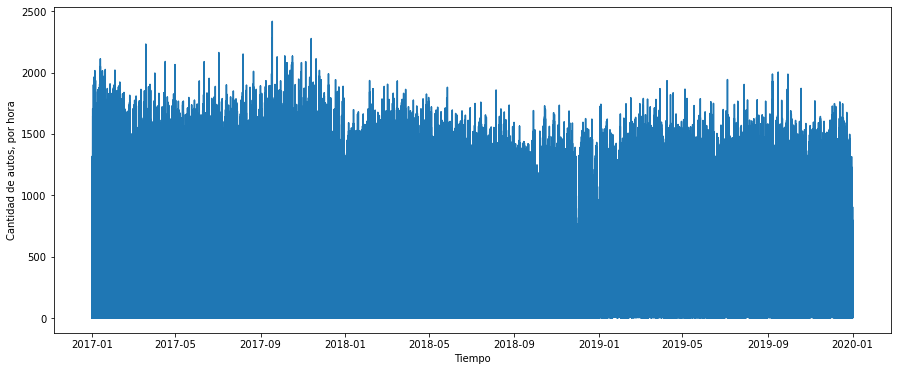

In [57]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [185]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

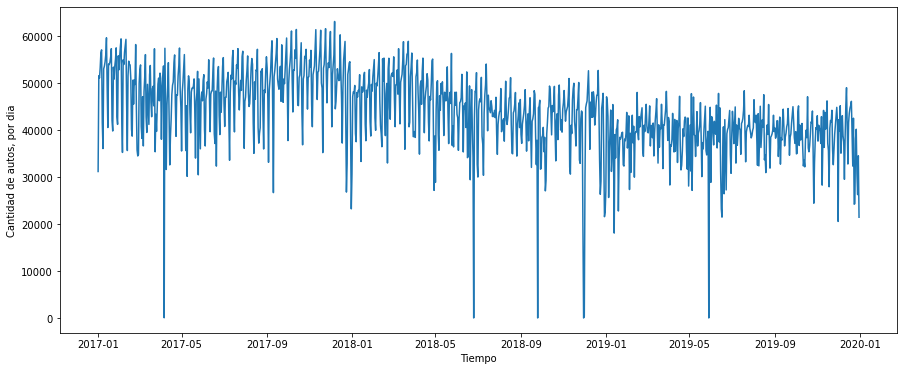

In [17]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [186]:
semanal = dataset.resample('W', on = 'fecha').sum()
print(semanal.shape)
semanal.head()

(158, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-08          347212
2017-01-15          366413
2017-01-22          357215
2017-01-29          354581

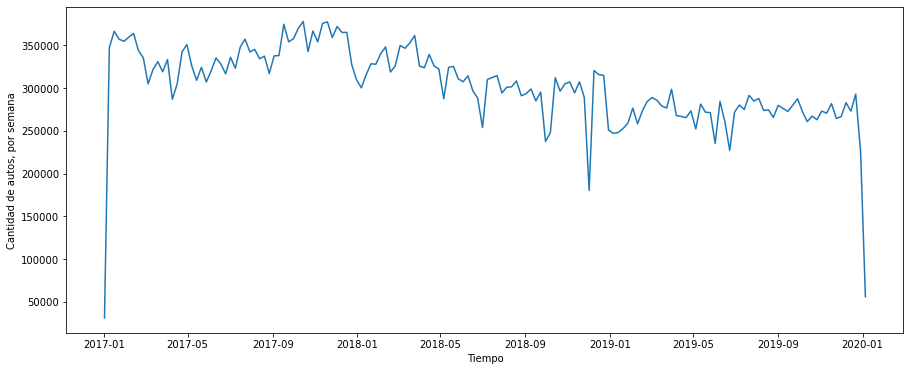

In [9]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

In [19]:
mensual = dataset.resample('M', on = 'fecha').sum()
print(mensual.shape)
mensual.head()

(36, 1)


cantidad_pasos
fecha                     
2017-01-31         1565260
2017-02-28         1363113
2017-03-31         1451214
2017-04-30         1373985
2017-05-31         1407136

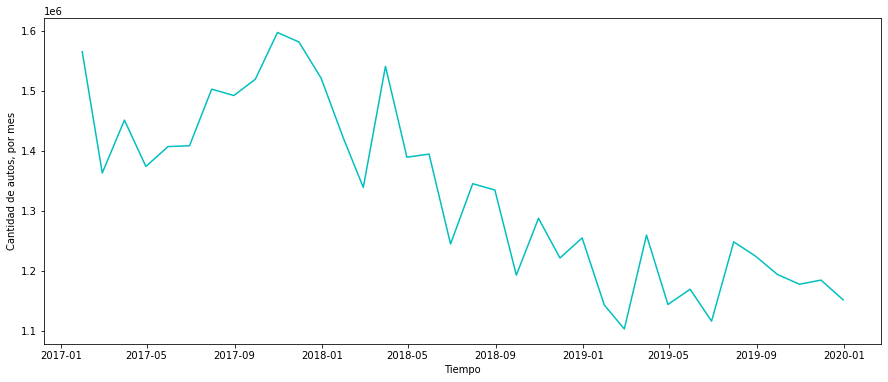

In [10]:
plt.figure(figsize = (15,6))
plt.plot(mensual.index, mensual.cantidad_pasos, color='c')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.show()

En base a los gráficos diario, semanal y mensual, se considera que la estacionalidad la tiene el diario. Por eso se utilizará este. El ruido se puede eliminar.

## I. Análisis Exploratorio de Datos
-------------

In [20]:
dataset.describe()

cantidad_pasos
count   238869.000000
mean       200.384232
std        403.246904
min          1.000000
25%          2.000000
50%         11.000000
75%        104.000000
max       2416.000000

/opt/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


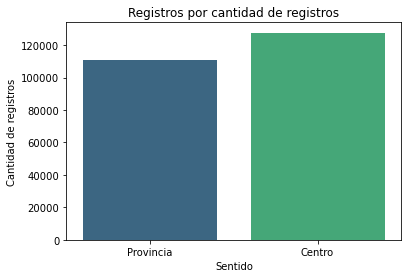

In [20]:
import seaborn as sns
sns.countplot(dataset.sentido, palette='viridis')
plt.title('Registros por cantidad de registros')
plt.xlabel('Sentido')
plt.ylabel('Cantidad de registros')
plt.show()

Con destino al centro hay más registros. 

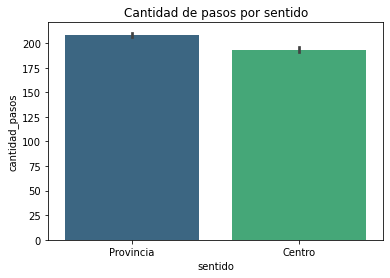

In [22]:
sns.barplot(x = 'sentido',y = 'cantidad_pasos',data = dataset, palette='viridis'  )
plt.title('Cantidad de pasos por sentido')
plt.show()

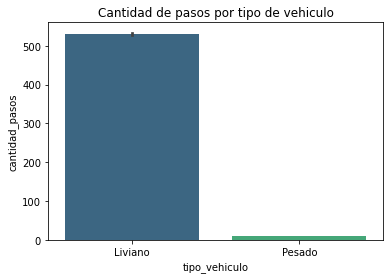

In [73]:
sns.barplot(x = 'tipo_vehiculo',y = 'cantidad_pasos',data = dataset, palette='viridis'  )
plt.title('Cantidad de pasos por tipo de vehiculo')
plt.show()

Considerando la diferencia entre vehiculos livianos y pesados que tenemos en el dataset, e sería bueno eliminar los vehiculos pesados y generar posteriormente un modelo para estos datos, ya que, al no estar proporcional pueden afectar como outliers. 

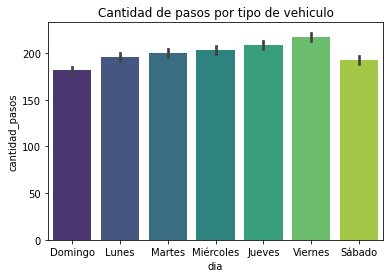

In [23]:
sns.barplot(x = 'dia',y = 'cantidad_pasos',data = dataset, palette='viridis'  )
plt.title('Cantidad de pasos por tipo de vehiculo')
plt.show()

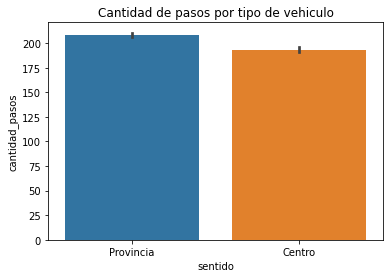

/opt/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


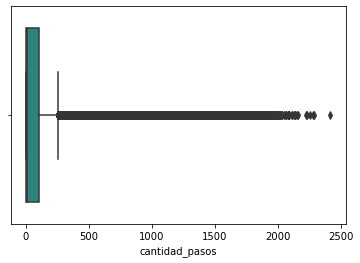

In [75]:
sns.boxplot(dataset.cantidad_pasos, palette='viridis')
plt.show()

/opt/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


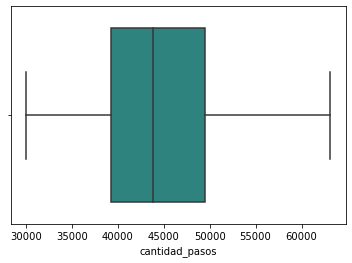

In [76]:
sns.boxplot(diario.cantidad_pasos, palette='viridis')
plt.show()

Vemos que existen claros outliers.

In [11]:
dataset.isnull().sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64

### I.I. Preguntas Generadas

#### ¿Es la tendencia de cada año similar?

In [24]:
semanal.reset_index(inplace = True)

In [25]:
semanal['semana'] = semanal.fecha.dt.isocalendar().week

In [26]:
semanal['anio'] = semanal.fecha.dt.year
semanal

fecha  cantidad_pasos  semana  anio
0   2017-01-01           31183      52  2017
1   2017-01-08          347212       1  2017
2   2017-01-15          366413       2  2017
3   2017-01-22          357215       3  2017
4   2017-01-29          354581       4  2017
..         ...             ...     ...   ...
153 2019-12-08          282891      49  2019
154 2019-12-15          272960      50  2019
155 2019-12-22          292881      51  2019
156 2019-12-29          226390      52  2019
157 2020-01-05           55970       1  2020

[158 rows x 4 columns]

In [16]:
semanal_2019 = semanal[semanal.anio == 2019].reset_index(drop=True)
semanal_2018 = semanal[semanal.anio == 2018].reset_index(drop=True)
semanal_2017 = semanal[semanal.anio == 2017].reset_index(drop=True)

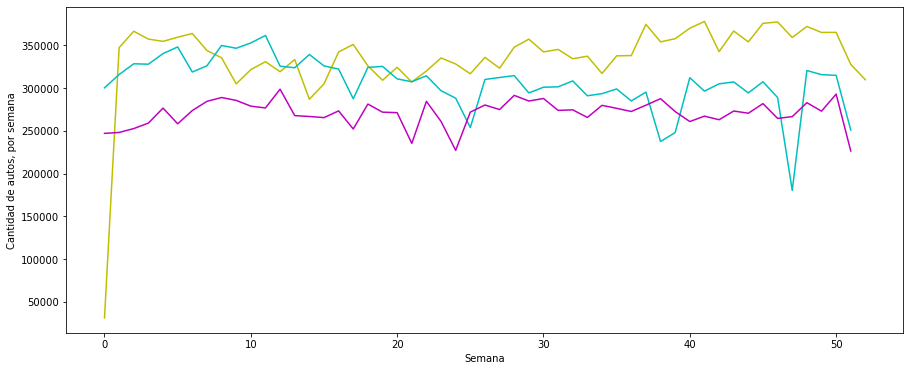

In [17]:
plt.figure(figsize = (15,6))
plt.plot(semanal_2017.cantidad_pasos, color = 'y')
plt.plot(semanal_2018.cantidad_pasos, color = 'c')
plt.plot(semanal_2019.cantidad_pasos, color = 'm')

plt.xlabel('Semana')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

El gráfico permite observar que la tendencia es bastante similar

#### ¿Cuáles son los horarios de mayor tráfico? 

In [22]:
hora = dataset.resample('H', on = 'fecha').sum()

In [23]:
import datetime as dt
dataset['horas'] = dataset.fecha.dt.hour

In [24]:
dia_horas = dataset.groupby(['dia','horas']).sum().reset_index()
dia_horas

dia  horas  cantidad_pasos
0    Domingo      0          175503
1    Domingo      1          174892
2    Domingo      2          158936
3    Domingo      3          126493
4    Domingo      4           84218
..       ...    ...             ...
163  Viernes     19          465097
164  Viernes     20          405452
165  Viernes     21          379383
166  Viernes     22          318075
167  Viernes     23          230267

[168 rows x 3 columns]

<AxesSubplot:xlabel='horas', ylabel='cantidad_pasos'>

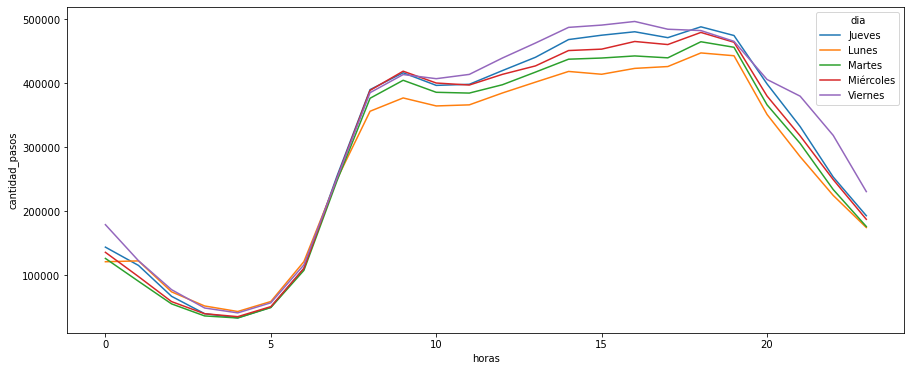

In [25]:
plt.figure(figsize = (15,6))
sns.lineplot(data = dia_horas[(dia_horas.dia != 'Sábado')&(dia_horas.dia != 'Domingo')], x = 'horas', y = 'cantidad_pasos', hue = 'dia')

<AxesSubplot:xlabel='horas', ylabel='cantidad_pasos'>

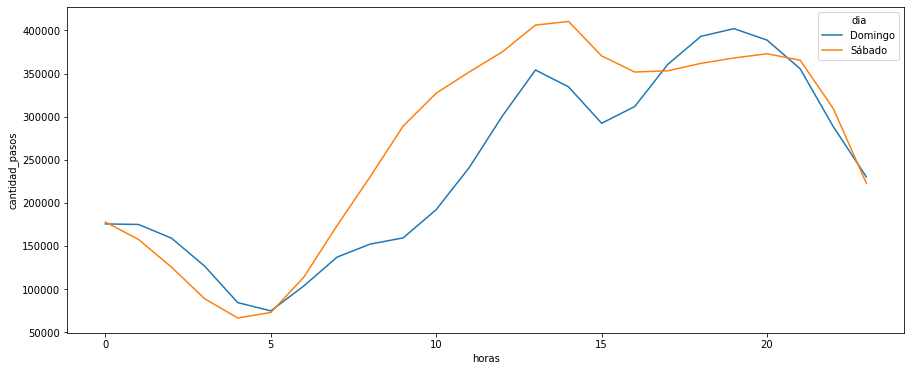

In [78]:
plt.figure(figsize = (15,6))
sns.lineplot(data = dia_horas[(dia_horas.dia == 'Sábado')|(dia_horas.dia == 'Domingo')], x = 'horas', y = 'cantidad_pasos', hue = 'dia')

Para ver los horarios, se decidió sacar Sábados y Domingos ya que tienen una tendencia muy diferente a los días de semana.

In [26]:
dia_horas = dataset.groupby(['dia','horas', 'sentido']).sum().reset_index()
dia_horas

dia  horas    sentido  cantidad_pasos
0    Domingo      0     Centro           91070
1    Domingo      0  Provincia           84433
2    Domingo      1     Centro           84397
3    Domingo      1  Provincia           90495
4    Domingo      2     Centro           75607
..       ...    ...        ...             ...
331  Viernes     21  Provincia          175224
332  Viernes     22     Centro          164624
333  Viernes     22  Provincia          153451
334  Viernes     23     Centro          112396
335  Viernes     23  Provincia          117871

[336 rows x 4 columns]

<AxesSubplot:xlabel='horas', ylabel='cantidad_pasos'>

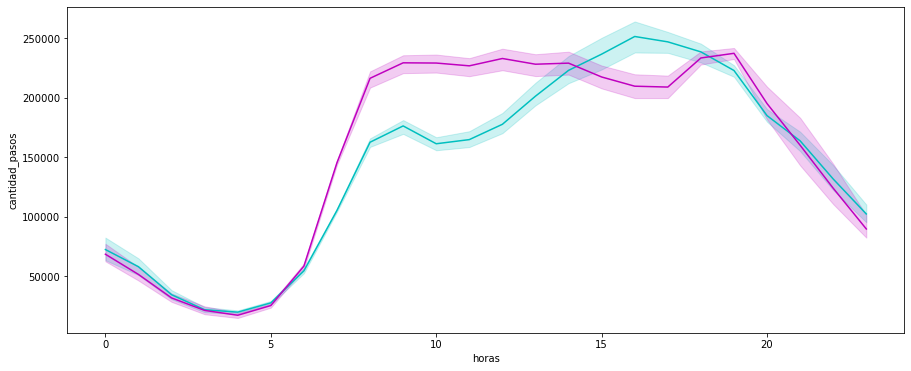

In [27]:
plt.figure(figsize = (15,6))
sns.lineplot(data = dia_horas[(dia_horas.dia != 'Sábado')&(dia_horas.dia != 'Domingo')&(dia_horas.sentido == 'Provincia')], x = 'horas', y = 'cantidad_pasos', color = 'c')
sns.lineplot(data = dia_horas[(dia_horas.dia != 'Sábado')&(dia_horas.dia != 'Domingo')&(dia_horas.sentido == 'Centro')], x = 'horas', y = 'cantidad_pasos', color = 'm')

Resulta interesante ver la diferencia entre la diferencia en horario del tránsito en dirección a centro vs la dirección provincia. El pico de movimiento en sentido Provincia es a las 16-17.

<AxesSubplot:xlabel='horas', ylabel='cantidad_pasos'>

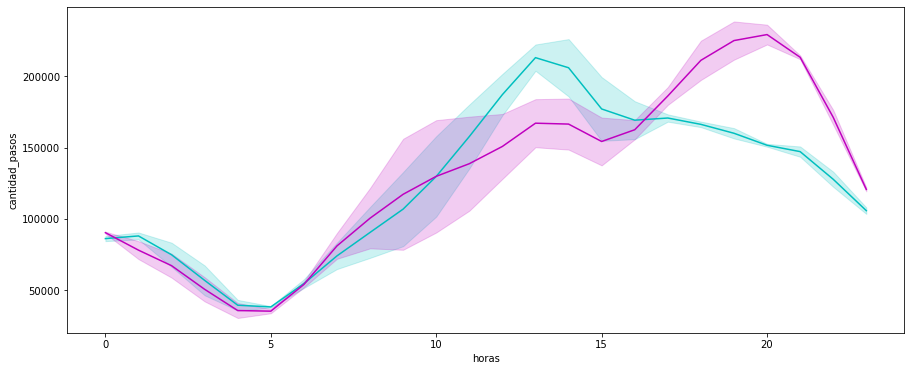

In [81]:
plt.figure(figsize = (15,6))
sns.lineplot(data = dia_horas[((dia_horas.dia == 'Sábado')|(dia_horas.dia == 'Domingo'))&(dia_horas.sentido == 'Provincia')], x = 'horas', y = 'cantidad_pasos', color= 'c')
sns.lineplot(data = dia_horas[((dia_horas.dia == 'Sábado')|(dia_horas.dia == 'Domingo'))&(dia_horas.sentido == 'Centro')], x = 'horas', y = 'cantidad_pasos', color = 'm')

Los Domingos a las 20 horas es el máximo de pasos en dirección al centro. Mientras que en dirección a provincia es al horario de Almuerzo.

# Diario
-------------

## Descomposición de la serie: Ruido, Tendencia, Estacionalidad y Anomalías

Para comenzar el análisis se trabajará en un primer momento con la serie *diaria*.

### Outliers 

Es importante tratar los outliers primero así luego no afectan. 

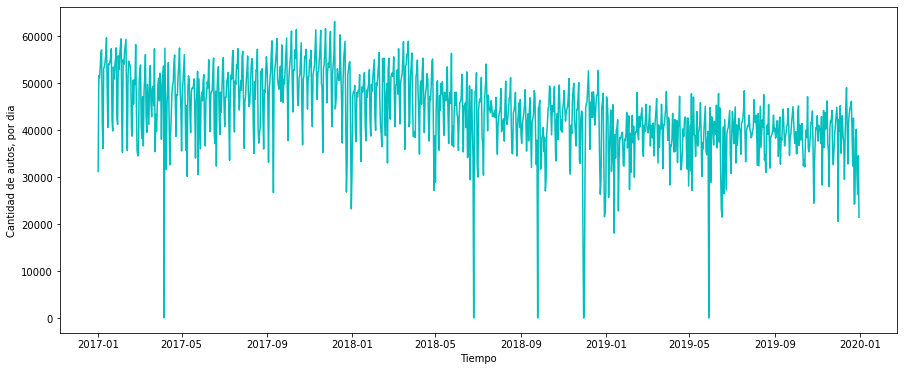

In [21]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos, color='c')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Este gráfico nos permite ver que hay valores atípicos en general debido a poca cantidad de pasos. Por ejemplo el 20 de marzo de 2019 estuvo cortada alrededor de seis horas por protestas.

In [12]:
diario.cantidad_pasos < 1

fecha
2017-01-01    False
2017-01-02    False
2017-01-03    False
2017-01-04    False
2017-01-05    False
              ...  
2019-12-27    False
2019-12-28    False
2019-12-29    False
2019-12-30    False
2019-12-31    False
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: bool

In [187]:
diario.cantidad_pasos[diario.cantidad_pasos < 30000] = np.nan

In [188]:
print(diario.isna().sum())
diario = diario.interpolate()
print(diario.isna().sum())

cantidad_pasos    42
dtype: int64
cantidad_pasos    0
dtype: int64


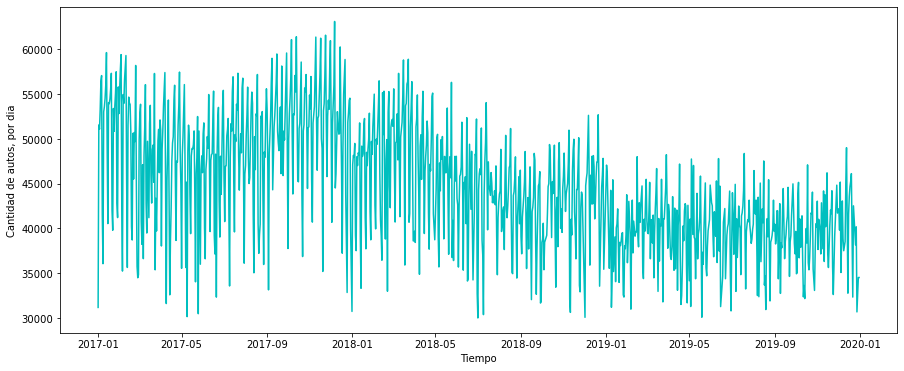

In [46]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos, color='c')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

/opt/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


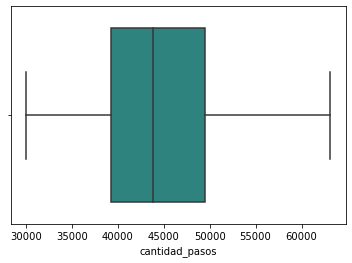

In [17]:
sns.boxplot(diario.cantidad_pasos, palette='viridis')
plt.show()

Se obtiene una reducción de los valores atípicos. 

### Ventanas Móviles

In [24]:
ventana = int(365*1/7)
diario_promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana, center = True).mean()

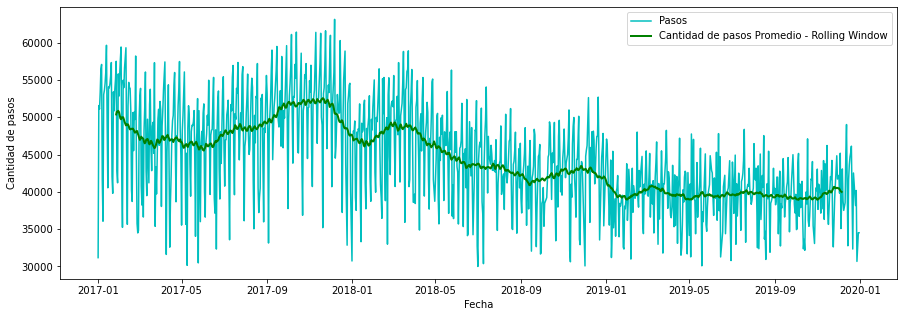

In [25]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Pasos', color='c')
plt.plot(diario_promedio_tendencia, lw = 2, label = 'Cantidad de pasos Promedio - Rolling Window', color='g')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

La media movil nos muestra que la cantidad de paso ha disminuido. Esto puede ser porque solamente estamos considerando los pagos en efectivo, entonces puede ser que existan más pagos ahora con telepase. 

#### Regresión lineal: Benchmark

Realizar una regresión lineal permite establecer una tendencia, para lo cual hay que ajustar las fechas.

In [26]:
diario['fecha_numeros']=diario.index.map(datetime.datetime.toordinal)
diario.head()

cantidad_pasos  fecha_numeros
fecha                                    
2017-01-01         31183.0         736330
2017-01-02         51568.0         736331
2017-01-03         51093.0         736332
2017-01-04         53332.0         736333
2017-01-05         56486.0         736334

In [27]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(diario.fecha_numeros.values.reshape(-1, 1), diario.cantidad_pasos)

LinearRegression()

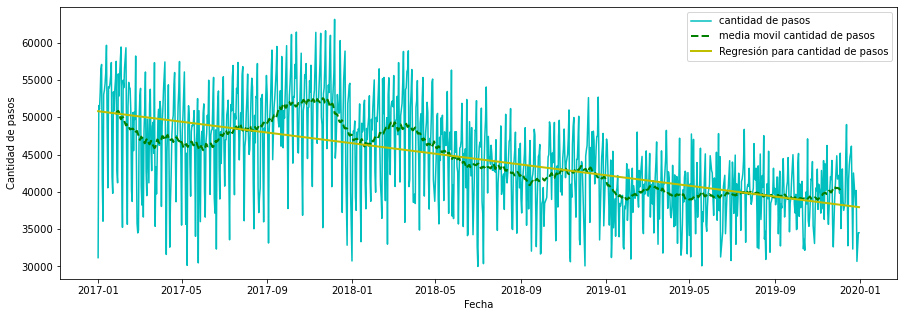

In [28]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos,label = 'cantidad de pasos', color='c')
plt.plot(diario_promedio_tendencia, ls = '--', lw = 2, label = 'media movil cantidad de pasos', color='g')
plt.plot(diario.index, lr.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 2, label = 'Regresión para cantidad de pasos', color='y')
# plt.xlim(datetime.date(1985,1,1), datetime.date(2018,1,1))
# plt.ylim([0,30])
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

La regresión lineal no captura el componente estacional y necesitamos capturarlo. Sin embargo si captura la tendencia que antes se pudo ver con la media movil. 

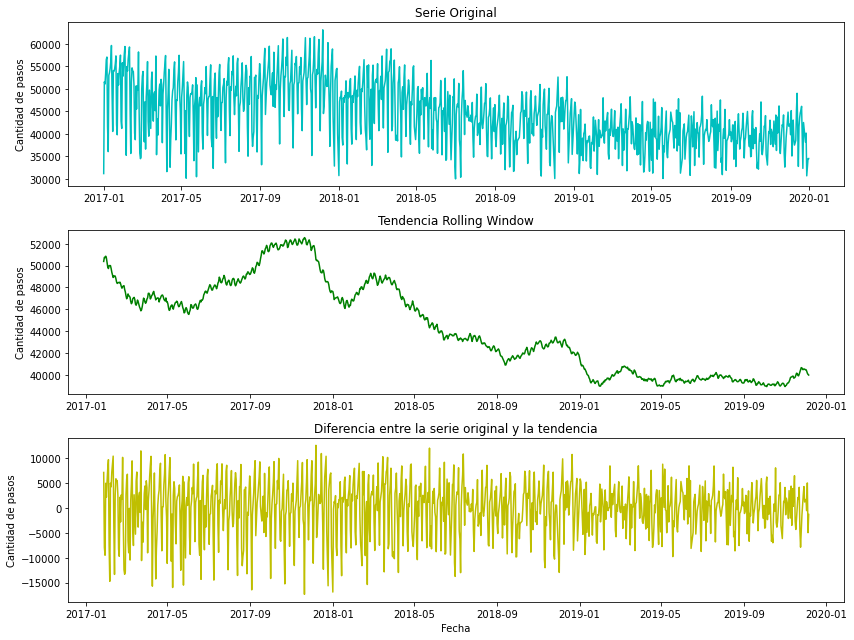

In [29]:
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario.index, diario.cantidad_pasos, color='c')
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(diario_promedio_tendencia, color='g')
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(diario.index, diario.cantidad_pasos - diario_promedio_tendencia, color='y')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')

plt.tight_layout()
plt.show()

Estos gráficos permitne visualizar los componentes por separado. El segundo gráfico muestra la tendencia (media movil). No es estacionaria en la media. 

En el tercer gráfico se muestra el componente estacional. Necesitamos hacer zoom al gráfico para poder apreciar más.

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(diario.cantidad_pasos, model='additive')

In [53]:
result.trend

fecha
2017-01-01             NaN
2017-01-02             NaN
2017-01-03             NaN
2017-01-04    48904.285714
2017-01-05    49601.714286
                  ...     
2019-12-27    36693.571429
2019-12-28    35757.333333
2019-12-29             NaN
2019-12-30             NaN
2019-12-31             NaN
Freq: D, Name: trend, Length: 1095, dtype: float64

In [54]:
result.seasonal

fecha
2017-01-01   -6333.000403
2017-01-02   -1058.890572
2017-01-03     198.294220
2017-01-04    1797.162276
2017-01-05    2979.887933
                 ...     
2019-12-27    4937.293381
2019-12-28   -2520.746835
2019-12-29   -6333.000403
2019-12-30   -1058.890572
2019-12-31     198.294220
Freq: D, Name: seasonal, Length: 1095, dtype: float64

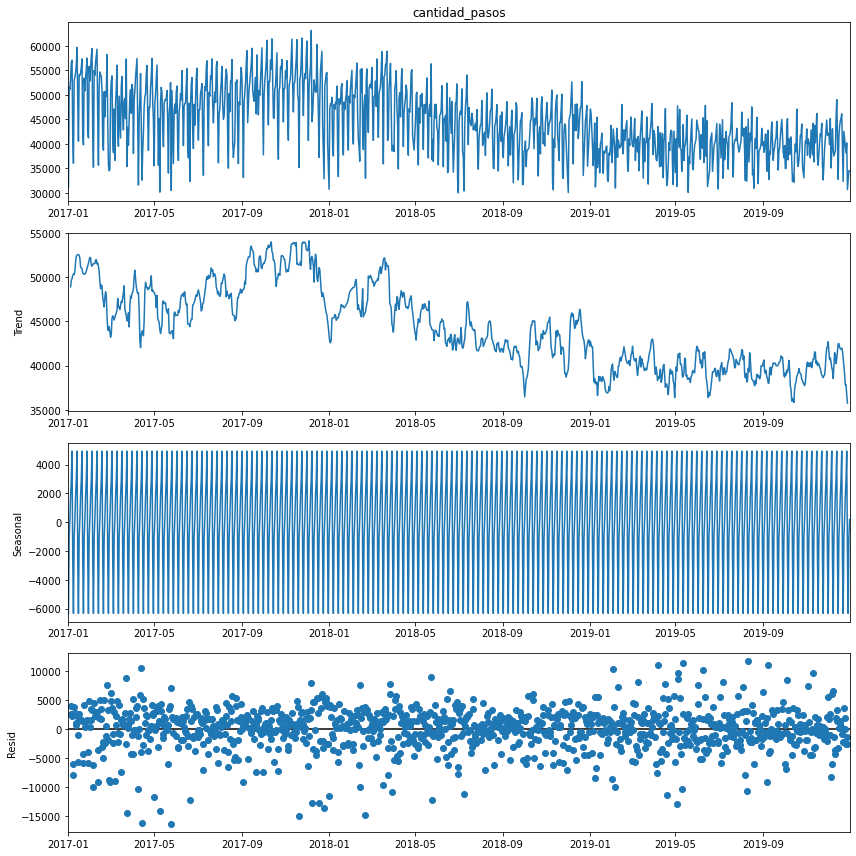

In [55]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

En el segundo gráfico, esta librería nos permite ver la tendencia más marcada. En el último gráfico podemos observar la distribución de los residuos, que están alrededor de 0.

#### Metodología de Box Jenkins

Como la serie de datos no es estacionaria, hay que hacerle transformación. 

In [31]:
from statsmodels.graphics.tsaplots import acf
from statsmodels.graphics.tsaplots import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

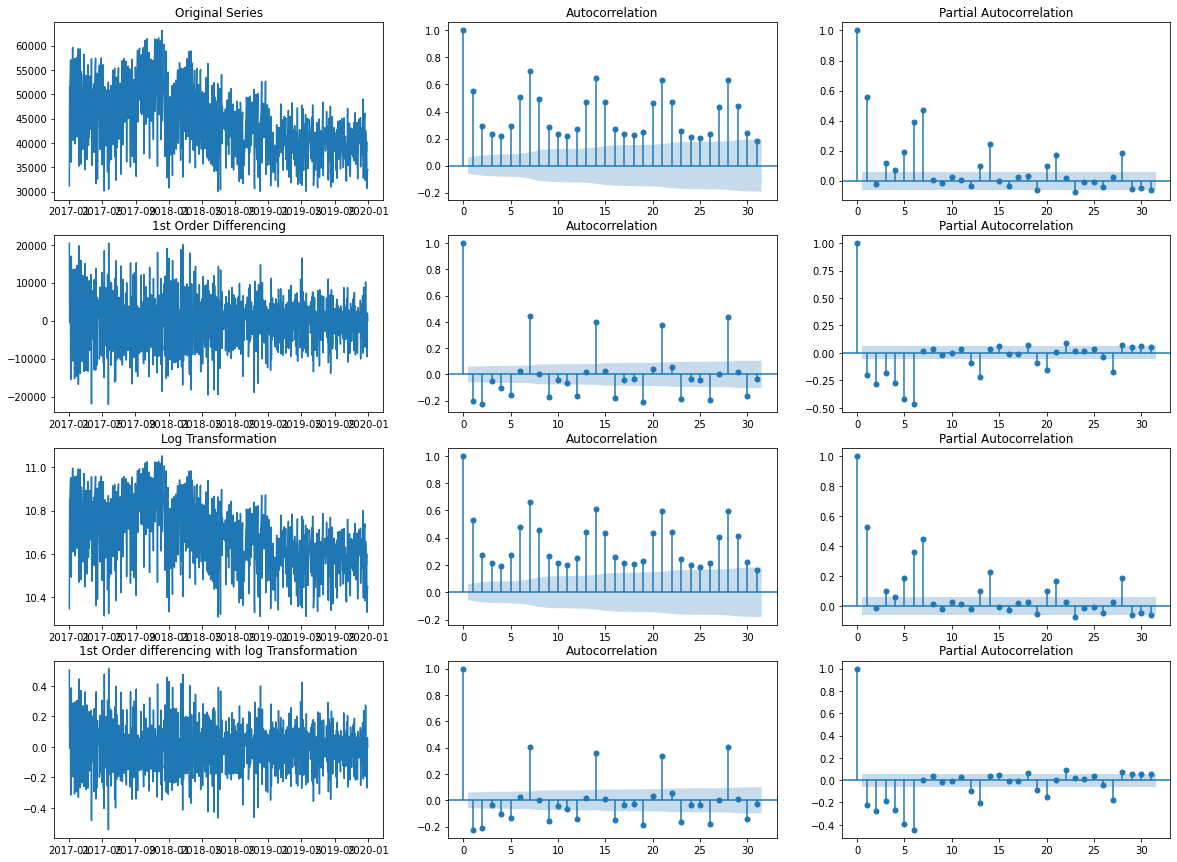

In [25]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, axes = plt.subplots(4,3,figsize = (20,15))
axes[0,0].plot(diario.cantidad_pasos);axes[0,0].set_title('Original Series')
plot_acf(diario.cantidad_pasos, ax = axes[0,1])
plot_pacf(diario.cantidad_pasos, ax = axes[0,2])

axes[1,0].plot(diario.cantidad_pasos.diff()); axes[1,0].set_title('1st Order Differencing')
plot_acf(diario.cantidad_pasos.diff().dropna(), ax = axes[1,1])
plot_pacf(diario.cantidad_pasos.diff().dropna(), ax = axes[1,2])

axes[2,0].plot(np.log(diario.cantidad_pasos)); axes[2,0].set_title('Log Transformation')
plot_acf(np.log(diario.cantidad_pasos).dropna(),ax = axes[2,1])
plot_pacf(np.log(diario.cantidad_pasos).dropna(),ax = axes[2,2])

axes[3,0].plot(np.log(diario.cantidad_pasos).diff()); axes[3,0].set_title('1st Order differencing with log Transformation')
plot_acf(np.log(diario.cantidad_pasos).diff().dropna(),ax = axes[3,1])
plot_pacf(np.log(diario.cantidad_pasos).diff().dropna(),ax = axes[3,2])

plt.show()

Del gráfico podemos considerar que sería importante hacer un 1st order differencing ya que la serie original no es estacionaria en la media. Esto quiere decir que se probará directamente con modelo ARIMA, descartando el modelo ARMA. 

Además surgen algunas ideas para probar en el modelo ARIMA.
- Diferencia: d=1
- Parámetro p: proceso regresivo - se mira autocorrelación parcial : R (p) 6
- Parámetro q: proceso media movil - se mira la autocorrelación: MA (q) 7 

In [56]:
from pmdarima.arima.utils import ndiffs
print(ndiffs(diario.cantidad_pasos,test='adf'))

0


In [57]:
diffClose = diario.cantidad_pasos.diff()
print(ndiffs(diffClose[1:],test = 'adf'))

0


Ambos métodos nos dicen que no es necesario diferencia, pero en el gráfico se observa que si es necesario.

### Train & Test Diario

In [189]:
train = diario.cantidad_pasos [:1000]
test = diario.cantidad_pasos[1000:1100]

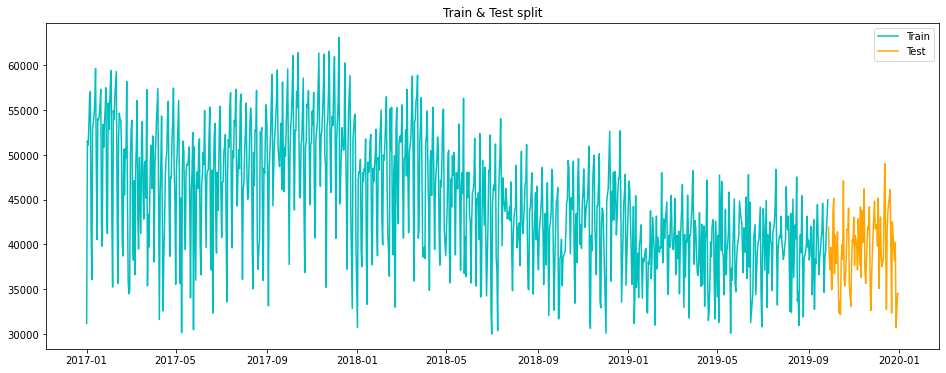

In [190]:
plt.figure (figsize=(16,6))
plt.plot(train, label='Train', color='c')
plt.plot(test, label='Test', color='orange')
plt.title('Train & Test split')
plt.legend()
plt.show()

### ARIMA: Buscando el mejor parámetro

La primer prueba es con los parámetros que surgieron de la interpretación de los gráficos:
- p: 6
- d: 1 La diferencia se hará manual
- q: 7

In [191]:
from statsmodels.tsa.arima.model import ARIMA

In [192]:
# create a differenced series
def difference (dataset, interval=1):
    diff =list()
    for i in range (interval, len(dataset)):
        value = dataset[i]-dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [193]:
# invert differenced value
def inverse_difference (history, yhat, interval=1):
    return yhat + history [-interval]

In [194]:
series = train
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)

# fit model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA (differenced, order =(6,0,7))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  635
Model:                 ARIMA(6, 0, 7)   Log Likelihood               -6402.662
Date:                Wed, 22 Sep 2021   AIC                          12835.323
Time:                        22:37:15   BIC                          12902.128
Sample:                             0   HQIC                         12861.263
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4926.3504   1.58e+04     -0.311      0.756    -3.6e+04    2.61e+04
ar.L1          0.8161      0.030     26.932      0.000       0.757       0.875
ar.L2         -0.4738      0.053     -8.964      0.0

/opt/miniconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


- El valor *z* para que sea un parámetro relevante tiene que ser > a 1.96 en valor absoluto. En base a esto consideramos irrelevantes el ma.L5 y ma.L6.
- De la interpretación de los intervalos en valor absoluto, se llega a la conclusión que nuevamente ma.L5 y ma.L6 son irrelevantes.
- Todavía tenemos que comparar modelo con el valor AIC, el menor será el mejor modelo en relación a parámetros pero no necesariamente prediciendo.

#### Obtener Residuos y Validar que sean Ruido Blanco

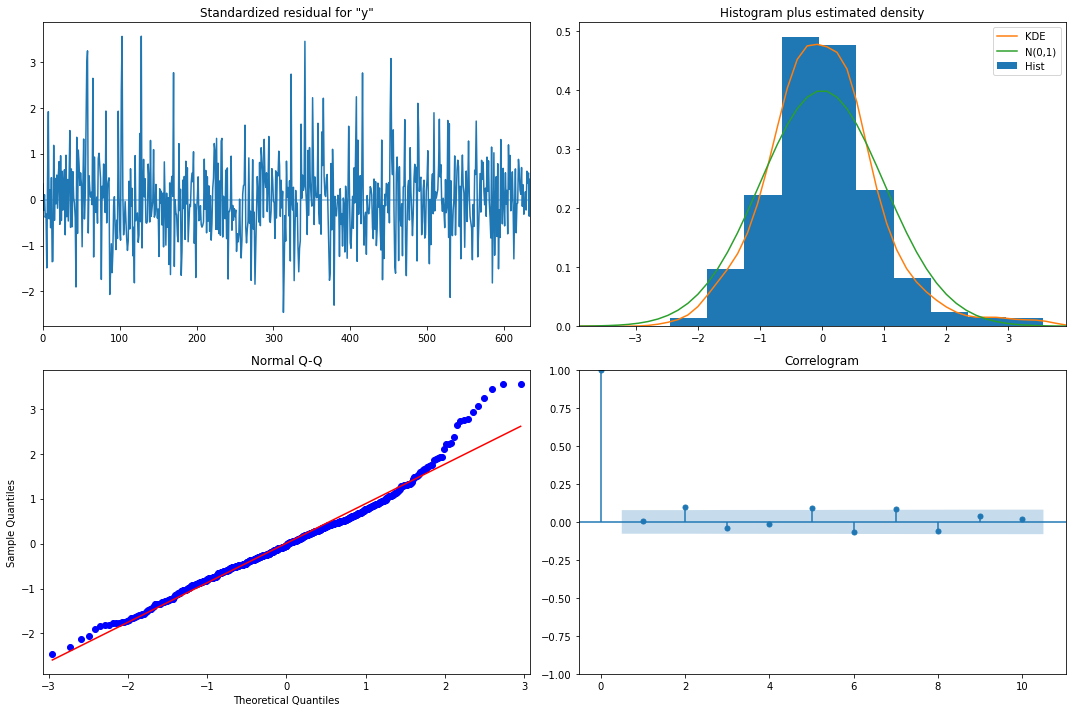

In [38]:
model_fit.plot_diagnostics(figsize=(15,10))
plt.tight_layout()
plt.show()

Del gráfico se puede interpretar que:
- Para que sea ruido blanco la media debería ser 0. En el gráfico podemos ver que la varianza no es constante. 
- La distribución de los errores no es normal. 
- Los errores no se ajustan mucho a la línea. Hay muchas observaciones de los errores que no son 0.

Esto parecería decir que no es ruido blanco, entonces el modelo no es bueno. Se decide no avanzar con este.

### ARIMA: Otros Parámetros

Es importante recordar que siempre es conveniente hacer modelos más simples, en este caso se probará ARIMA con parámetros 2, 1, 2.

In [195]:
series = train
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)

# fit model
model = ARIMA (differenced, order =(2,0,2))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  635
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -6517.834
Date:                Wed, 22 Sep 2021   AIC                          13047.668
Time:                        22:37:18   BIC                          13074.390
Sample:                             0   HQIC                         13058.044
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4926.3499   1875.576     -2.627      0.009   -8602.412   -1250.288
ar.L1          0.5473      0.165      3.319      0.001       0.224       0.871
ar.L2          0.4393      0.161      2.736      0.0

- El valor *z* como es  > a 1.96 en todos los casos. (todos son relevantes).
- De la interpretación de los intervalos en valor absoluto, se llega a la conclusión que todos son relevantes.
- Todavía tenemos que comparar modelo con el valor AIC, el menor será el mejor modelo en relación a parámetros pero no necesariamente prediciendo.

In [196]:
forecast = model_fit.forecast(steps=90)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 44591.180199
Day 2: 29030.671489
Day 3: 29569.845362
Day 4: 35987.044141
Day 5: 36359.217832
Day 6: 38104.399021
Day 7: 32900.330713
Day 8: 35944.390960
Day 9: 36182.339965
Day 10: 36416.349153
Day 11: 36652.400100
Day 12: 39070.504285
Day 13: 42053.169760
Day 14: 42357.872939
Day 15: 46710.843354
Day 16: 45877.976601
Day 17: 40846.316379
Day 18: 36257.840736
Day 19: 42466.556857
Day 20: 41134.459031
Day 21: 42936.547287
Day 22: 46498.819132
Day 23: 36970.273216
Day 24: 30592.907703
Day 25: 39210.720996
Day 26: 40594.711413
Day 27: 35061.877332
Day 28: 44542.217129
Day 29: 46651.729199
Day 30: 41343.411952
Day 31: 37028.263812
Day 32: 39182.283217
Day 33: 36549.468622
Day 34: 41452.818493
Day 35: 42753.331312
Day 36: 45359.005574
Day 37: 41688.839790
Day 38: 38802.832482
Day 39: 40782.982188
Day 40: 41368.287457
Day 41: 41861.746855
Day 42: 44023.358957
Day 43: 47799.122353
Day 44: 28890.035649
Day 45: 27413.097458
Day 46: 37798.306411
Day 47: 36020.661148
Day 48: 43193.160324
D

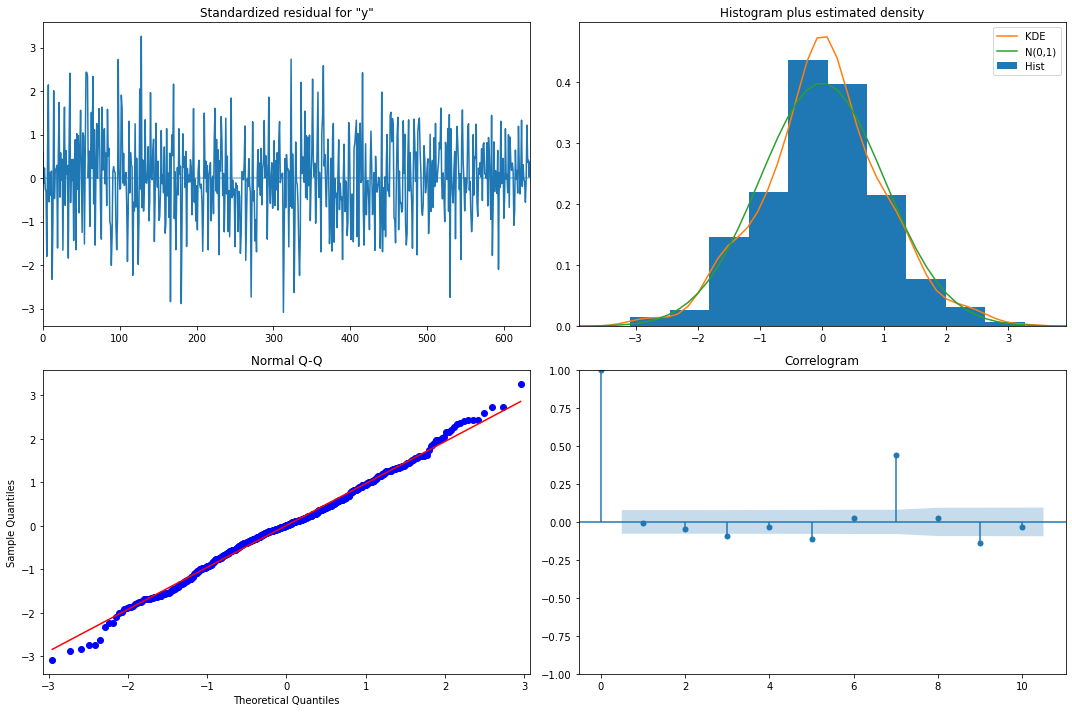

In [41]:
model_fit.plot_diagnostics(figsize=(15,10))
plt.tight_layout()
plt.show()

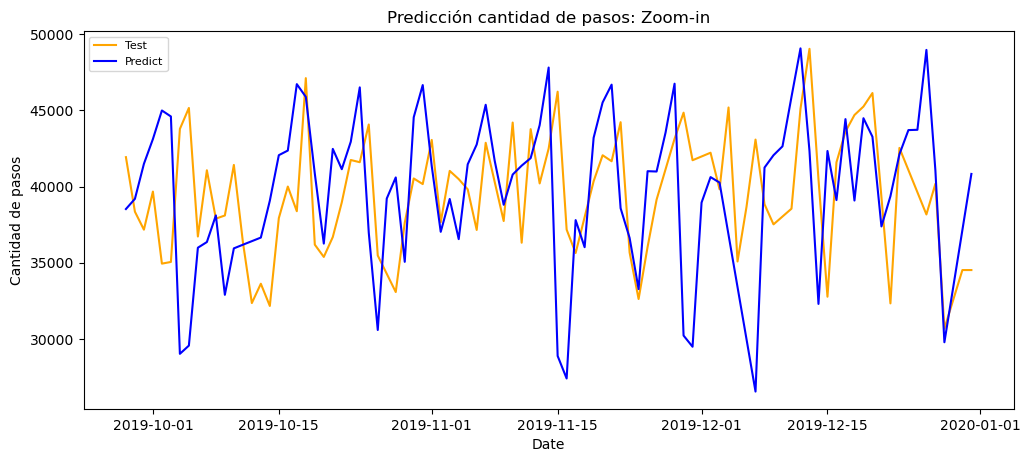

In [42]:
import pandas as pd 

plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test.index, test,label = 'Test', color='orange')
plt.plot(test.index, history[-95:], color = 'blue', label = 'Predict')
plt.title('Predicción cantidad de pasos: Zoom-in')
plt.xlabel('Date')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

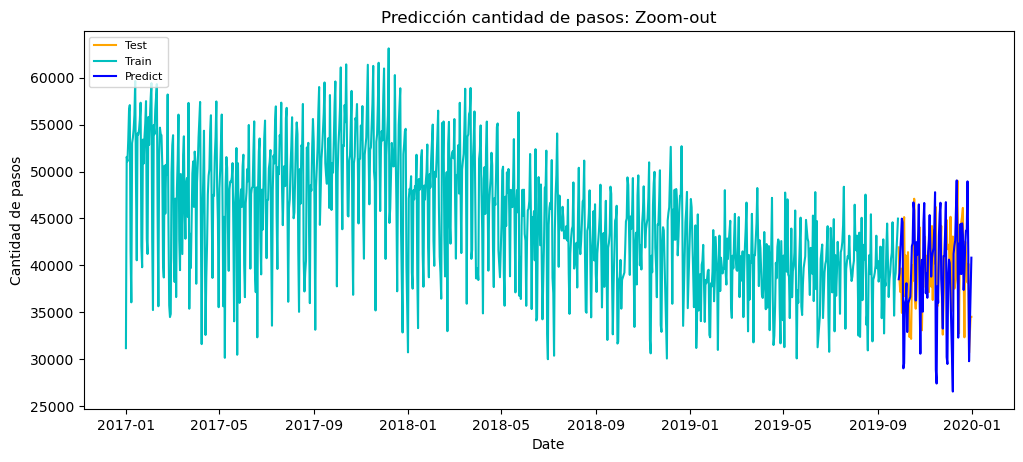

In [43]:
import pandas as pd 

plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test.index, test,label = 'Test', color='orange')
plt.plot(train,label = 'Train', color='c')
plt.plot(test.index, history[-95:], color = 'blue', label = 'Predict')
plt.title('Predicción cantidad de pasos: Zoom-out')
plt.xlabel('Date')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [197]:
results = pd.DataFrame (test, index=test.index)
results.columns = ['real']
results['arima_oos'] = history[-95:]
results.head(20)

real     arima_oos
fecha                            
2019-09-28  41925.0  38523.000000
2019-09-29  38348.0  39191.000000
2019-09-30  37170.0  41486.000000
2019-10-01  39669.0  43110.000000
2019-10-02  34943.0  44985.000000
2019-10-03  35054.0  44591.180199
2019-10-04  43775.0  29030.671489
2019-10-05  45150.0  29569.845362
2019-10-06  36722.0  35987.044141
2019-10-07  41064.0  36359.217832
2019-10-08  37894.0  38104.399021
2019-10-09  38100.0  32900.330713
2019-10-10  41414.0  35944.390960
2019-10-11  36383.0  36182.339965
2019-10-12  32359.0  36416.349153
2019-10-13  33626.0  36652.400100
2019-10-14  32168.0  39070.504285
2019-10-15  37928.0  42053.169760
2019-10-16  39997.0  42357.872939
2019-10-17  38379.0  46710.843354

In [198]:
rmse_arima_oos = np.sqrt(mean_squared_error(test, results.arima_oos))
print(('RMSE ARIMA out-of-sample diario:'), rmse_arima_oos)
mae_arima_oos =metrics.mean_absolute_error(test, results.arima_oos)
print('MAE ARIMA out-of-sample diario:', mae_arima_oos)
mape_arima_oos = np.mean(np.abs(results.arima_oos - test)/np.abs(test))
print('MAPE ARIMA out-of-sample diario:',mape_arima_oos)

RMSE ARIMA out-of-sample diario: 5921.060794559261
MAE ARIMA out-of-sample diario: 4561.138207731392
MAPE ARIMA out-of-sample diario: 0.1154437674139565


### AUTOARIMA

In [199]:
from pmdarima.arima import auto_arima
arima = auto_arima(train, start_p = 0,start_d=0,start_q = 0,
                       max_p = 5,max_d = 3,max_q = 5)

In [48]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -9797.508
Date:                Wed, 22 Sep 2021   AIC                          19617.016
Time:                        20:52:50   BIC                          19670.990
Sample:                             0   HQIC                         19637.531
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0304      0.045     22.977      0.000       0.943       1.118
ar.L2         -1.6137      0.037    -43.716      0.000      -1.686      -1.541
ar.L3          1.1005      0.062     17.623      0.0

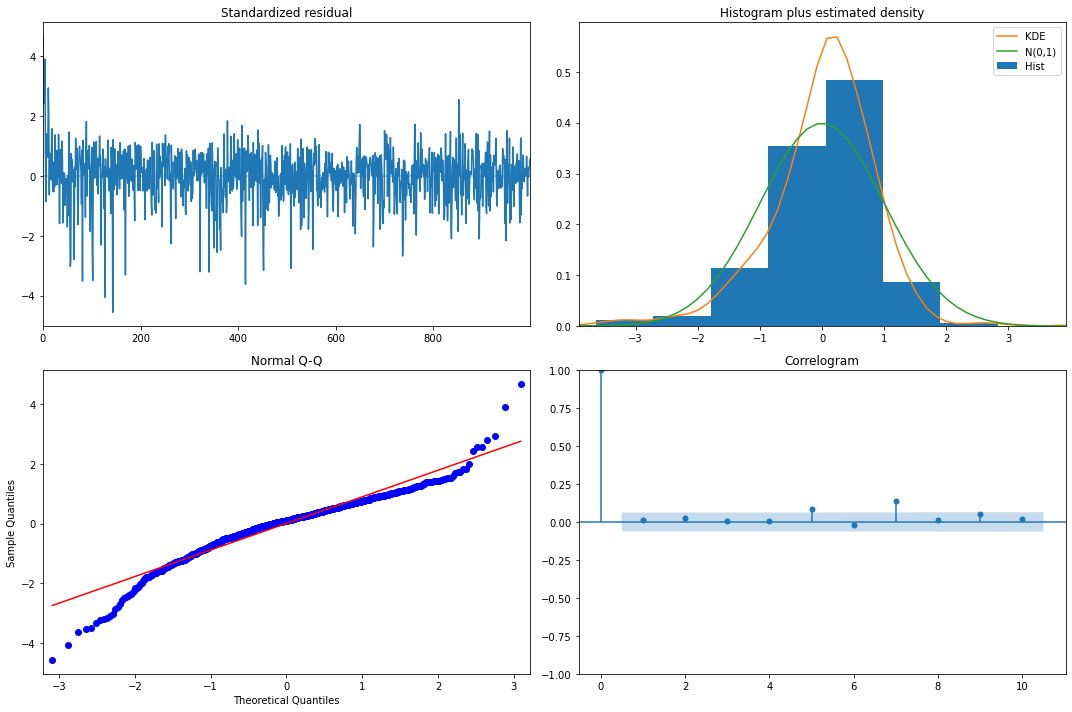

In [49]:
arima.plot_diagnostics(figsize=(15,10))
plt.tight_layout()
plt.show()

Del gráfico se puede interpretar que:

La distribución de los errores no es normal.
Los errores no tienden a ajustarse a la línea, aunque hay observaciones que si. Esto parecería indicar que en gran medida *no* es ruido blanco.

### Machine Learning: *Random Forest Regressor*

In [200]:
look_back = 90

In [201]:
diario_rf = diario.cantidad_pasos
diario_rf.head()

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [202]:
N = diario_rf.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1004, 90) (1004,)


In [203]:
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = diario_rf.iloc[i:i+look_back]
    y[i] = diario_rf.iloc[i+look_back]

In [217]:
N_train = 1004 - look_back 
N_test =  90
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(914, 90) (914,)
(90, 90) (90,)


In [218]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp 

rf = RandomForestRegressor()

In [219]:
rs_cv = RandomizedSearchCV(rf, cv=5, n_iter=10, random_state=42, 
                           param_distributions={'max_features': sp.stats.randint(1,50),
                                                'n_estimators': sp.stats.randint(1,50)})

In [220]:
rs_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1437b4b50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x126dc13d0>},
                   random_state=42)

In [221]:
print('Los mejores Parametros :'+str(rs_cv.best_params_))
print('El mejor Score: ' +str(rs_cv.best_score_)+'n')

Los mejores Parametros :{'max_features': 39, 'n_estimators': 29}
El mejor Score: 0.3588362743595347n


In [223]:
rf = RandomForestRegressor(n_estimators=29, max_features= 39 ,random_state=42, n_jobs = 4).fit(X_train,y_train)

Un modelo puede ser mejor prediciendo la parte estacional pero no predicción forecasting.

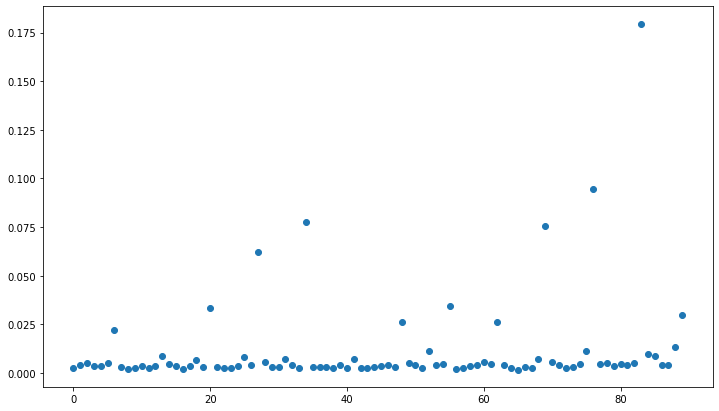

In [224]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)

plt.show()

In [225]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

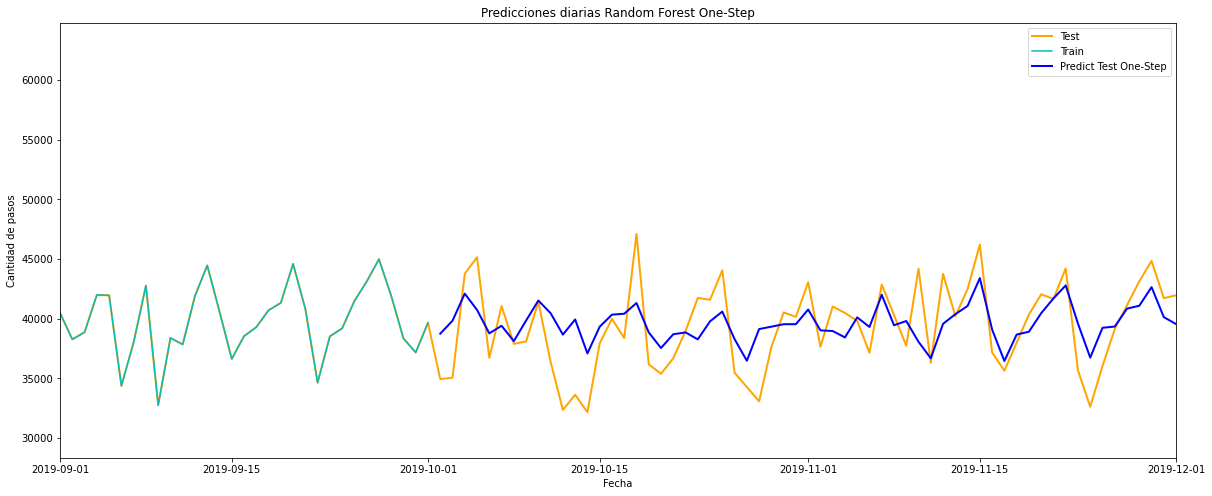

In [226]:
plt.figure(figsize=(20,8))
plt.plot(diario_rf.index[:length_total], diario_rf[:length_total],lw = 2, label = 'Test', color='orange')
plt.plot(diario_rf.index[:N_train + look_back], diario_rf[:N_train + look_back], label = 'Train', color='c')
plt.plot(diario_rf.index[N_train+look_back: length_total], y_test_pred, lw = 2, label = 'Predict Test One-Step', color='b')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.title('Predicciones diarias Random Forest One-Step')
plt.axis(xmax = '2019-12-01'  , xmin = '2019-09-01')
plt.show()

In [227]:
rmse_rf_os = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(('RMSE Random forest One Step:'), rmse_rf_os)
mae_rf_os =metrics.mean_absolute_error(y_test, y_test_pred)
print('MAE Random forest One Step:', mae_rf_os)
mape_rf_os = np.mean(np.abs(y_test_pred - y_test)/np.abs(y_test))
print('MAPE Random forest One Step:',mape_rf_os)

RMSE Random forest One Step: 3167.334355160505
MAE Random forest One Step: 2526.5274904214557
MAPE Random forest One Step: 0.06595776325966617


#### Multi-Step Prediction

In [228]:
y_ms_test_pred = []
x = X_test[0,:] 
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

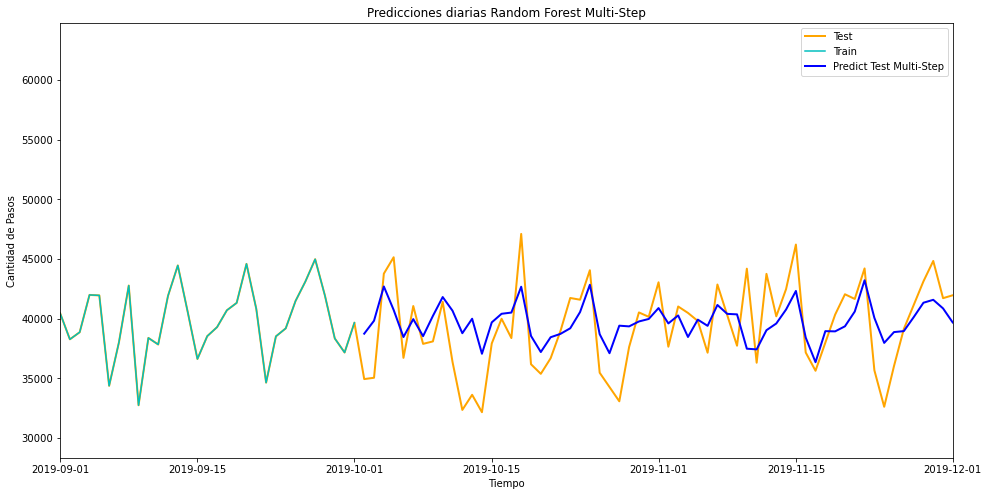

In [229]:
plt.figure(figsize=(16,8))
plt.plot(diario_rf.index[:length_total], diario_rf[:length_total],lw = 2, label = 'Test', color='orange')
plt.plot(diario_rf.index[:N_train + look_back], diario_rf[:N_train + look_back], label = 'Train', color='c')
plt.plot(diario_rf.index[N_train+look_back: length_total], y_ms_test_pred, lw = 2, label = 'Predict Test Multi-Step', color='b')
plt.legend()
plt.axis(xmax = '2019-12-01'  , xmin = '2019-09-01')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.title('Predicciones diarias Random Forest Multi-Step')
plt.show()

In [230]:
rmse_rf_ms = np.sqrt(mean_squared_error(y_test, y_ms_test_pred))
print(('RMSE Random forest Multi Step:'), rmse_rf_ms)
mae_rf_ms =metrics.mean_absolute_error(y_test, y_ms_test_pred)
print('MAE Random forest Multi Step:', mae_rf_ms)
mape_rf_ms = np.mean(np.abs(y_ms_test_pred - y_test)/np.abs(y_test))
print('MAPE Random forest Multi Step:',mape_rf_ms)

RMSE Random forest Multi Step: 3341.4019919492584
MAE Random forest Multi Step: 2650.9224457215832
MAPE Random forest Multi Step: 0.0881920306269069


# SEMANAL
-------------

In [231]:
semanal = diario.resample("W", closed='left').mean()

In [232]:
semanal = semanal[(semanal.index> '2017-01-01')&(semanal.index< '2019-12-29')]
semanal

cantidad_pasos
fecha                     
2017-01-08    48904.285714
2017-01-15    51704.571429
2017-01-22    51136.714286
2017-01-29    50452.428571
2017-02-05    52196.428571
...                    ...
2019-11-24    39653.214286
2019-12-01    39803.571429
2019-12-08    40860.071429
2019-12-15    41077.000000
2019-12-22    41902.571429

[155 rows x 1 columns]

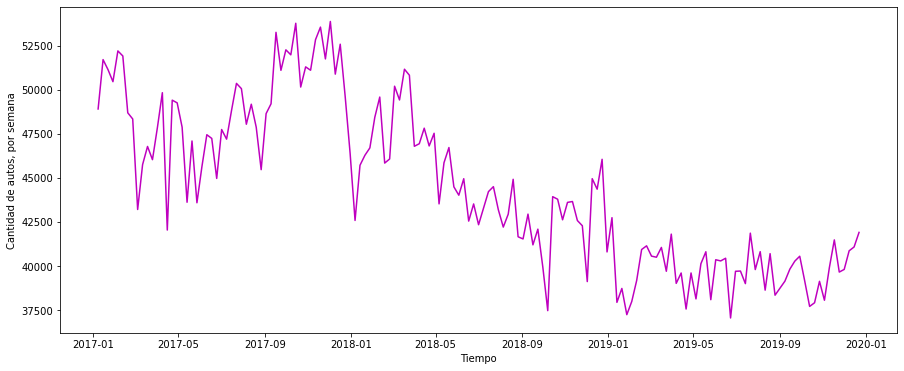

In [72]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos, color='m')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

/opt/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


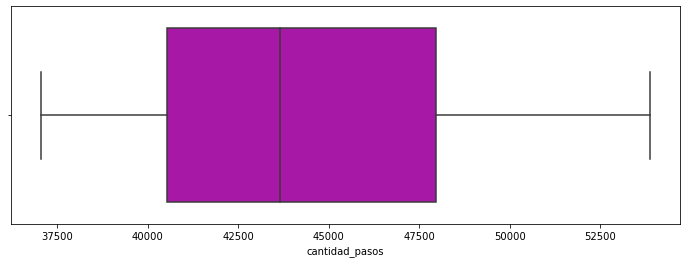

In [73]:
plt.figure(figsize = (12,4))
sns.boxplot(semanal.cantidad_pasos, color='m')
plt.show()

In [74]:
ventana = int(52*1/3)
semanal_promedio_tendencia = semanal.cantidad_pasos.rolling(window=ventana, center = True).mean()

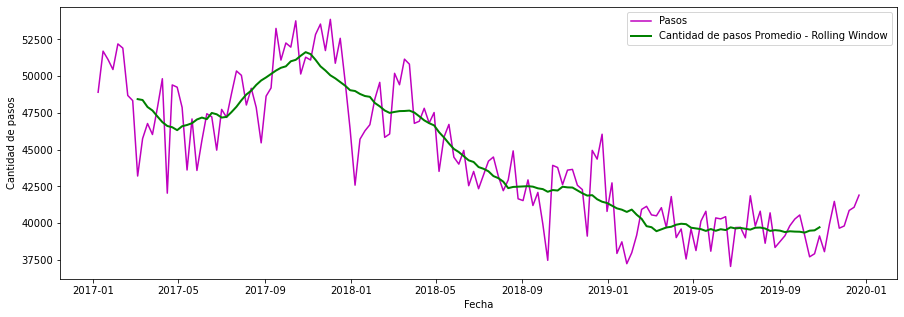

In [75]:
plt.figure(figsize = (15,5))
plt.plot(semanal.index, semanal.cantidad_pasos, label = 'Pasos', color='m')
plt.plot(semanal_promedio_tendencia, lw = 2, label = 'Cantidad de pasos Promedio - Rolling Window', color='g')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

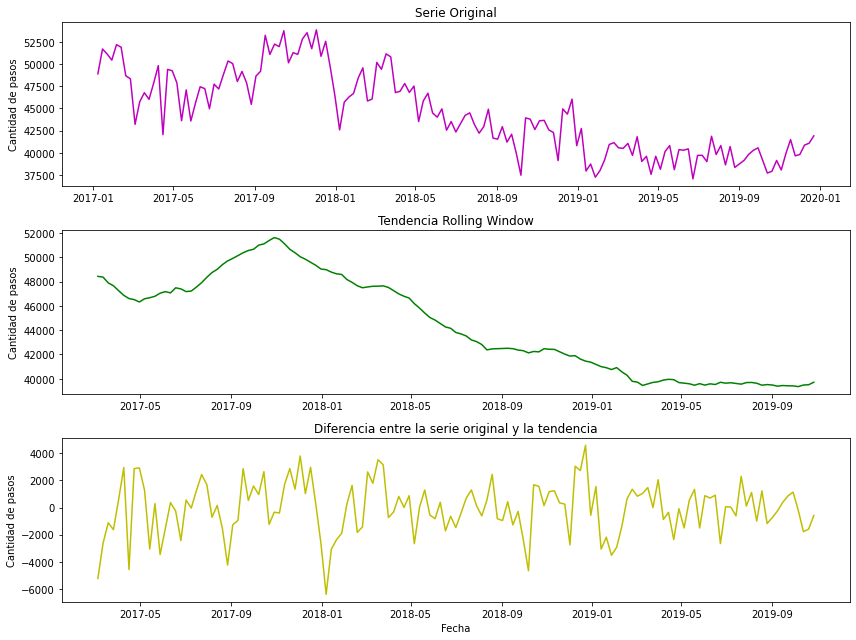

In [124]:
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(semanal.index, semanal.cantidad_pasos, color='m')
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(semanal_promedio_tendencia, color='g')
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(semanal.index, semanal.cantidad_pasos - semanal_promedio_tendencia, color='y')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')

plt.tight_layout()
plt.show()

#### Regresión lineal: Benchmark

Realizar una regresión lineal permite establecer una tendencia, para lo cual hay que ajustar las fechas.

In [233]:
semanal['fecha_numeros']=semanal.index.map(datetime.datetime.toordinal)
semanal.head()

cantidad_pasos  fecha_numeros
fecha                                    
2017-01-08    48904.285714         736337
2017-01-15    51704.571429         736344
2017-01-22    51136.714286         736351
2017-01-29    50452.428571         736358
2017-02-05    52196.428571         736365

In [234]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(semanal.fecha_numeros.values.reshape(-1, 1), semanal.cantidad_pasos)

LinearRegression()

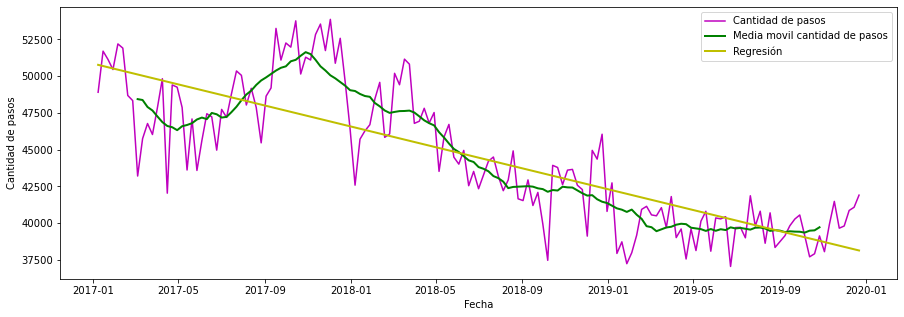

In [78]:
plt.figure(figsize = (15,5))
plt.plot(semanal.index, semanal.cantidad_pasos,label = 'Cantidad de pasos', color='m')
plt.plot(semanal_promedio_tendencia, lw = 2, label = 'Media movil cantidad de pasos', color='g')
plt.plot(semanal.index, lr.predict(semanal.fecha_numeros.values.reshape(-1, 1)), lw = 2, label = 'Regresión', color='y')
# plt.xlim(datetime.date(1985,1,1), datetime.date(2018,1,1))
# plt.ylim([0,30])
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

In [79]:
result_semanal = seasonal_decompose(semanal.cantidad_pasos, model='additive')

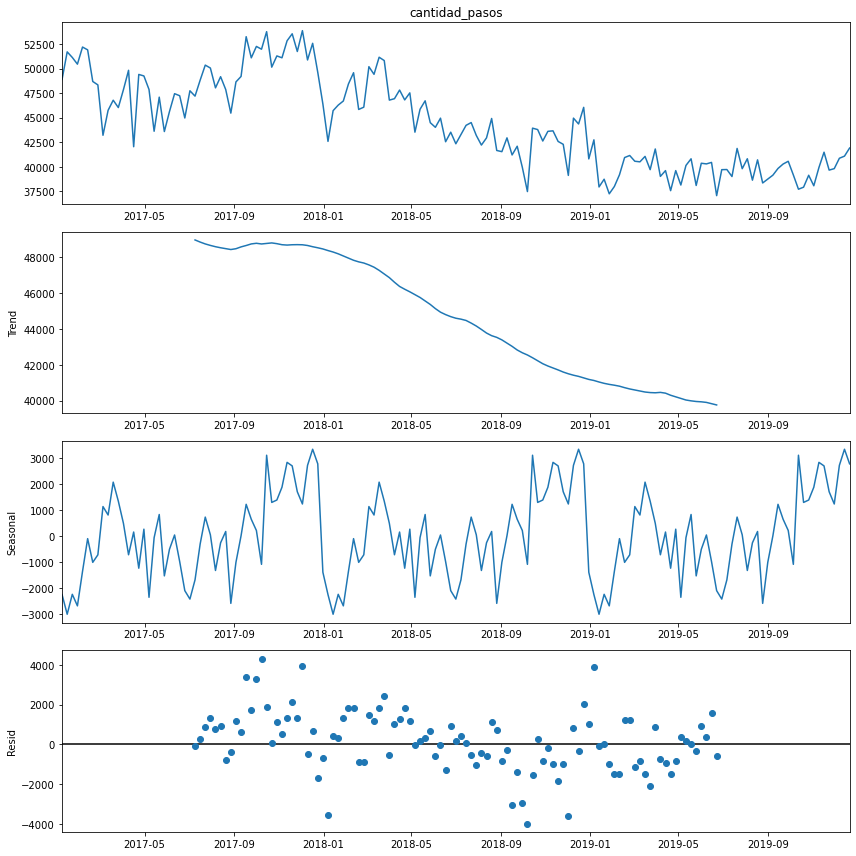

In [305]:
matplotlib.rcParams['figure.figsize'] = [12,12]
result_semanal.plot()
plt.show()

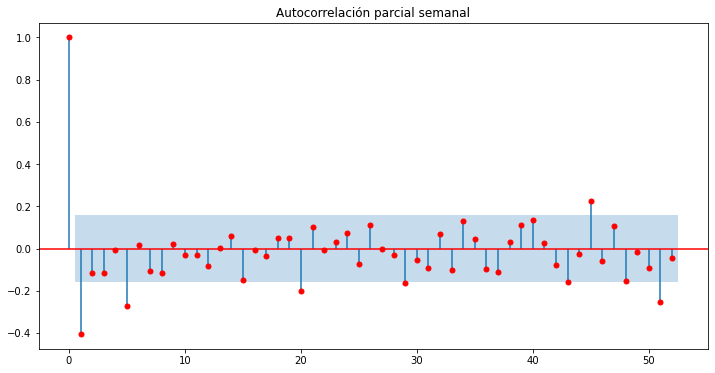

In [81]:

fig, ejes = plt.subplots(figsize=(12,6))
plot_pacf(semanal.cantidad_pasos.diff().dropna(), lags=52, ax=ejes,color="red", title='Autocorrelación parcial semanal')
plt.show()

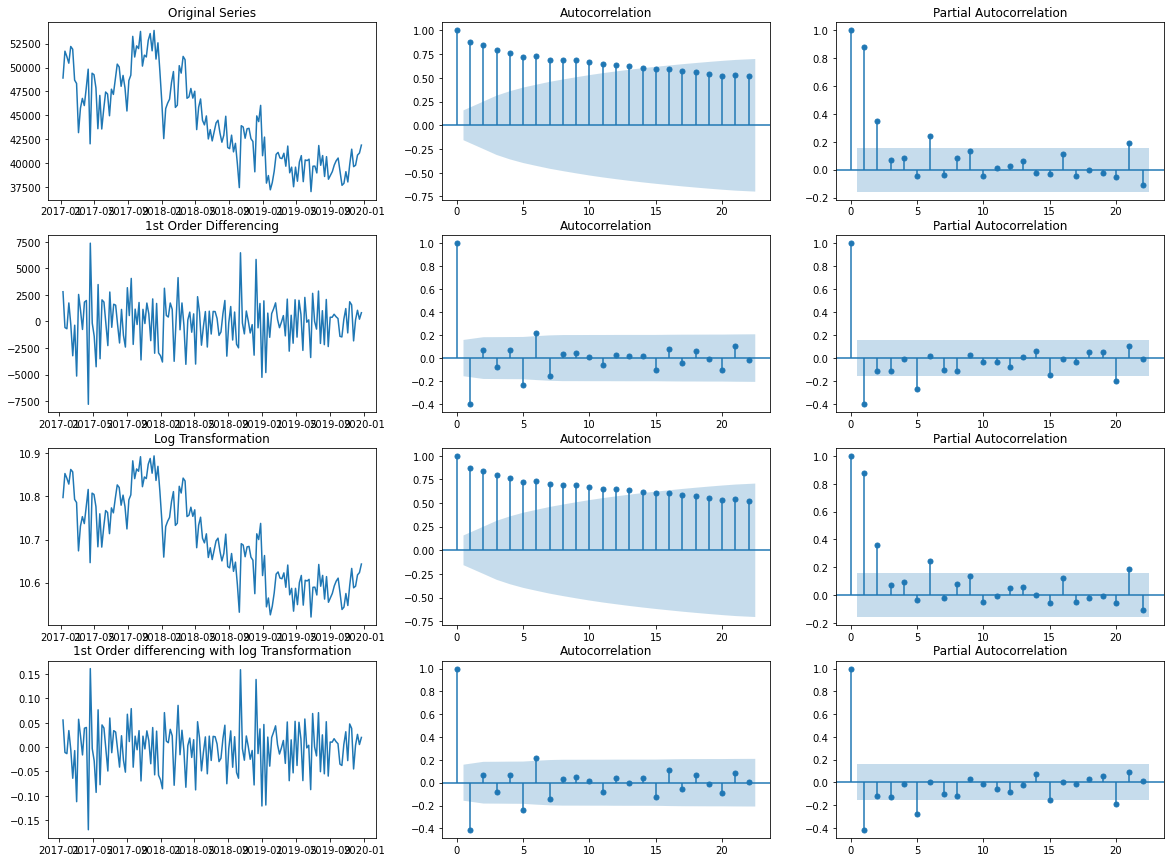

In [82]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, axes = plt.subplots(4,3,figsize = (20,15))
axes[0,0].plot(semanal.cantidad_pasos);axes[0,0].set_title('Original Series')
plot_acf(semanal.cantidad_pasos, ax = axes[0,1])
plot_pacf(semanal.cantidad_pasos, ax = axes[0,2])

axes[1,0].plot(semanal.cantidad_pasos.diff()); axes[1,0].set_title('1st Order Differencing')
plot_acf(semanal.cantidad_pasos.diff().dropna(), ax = axes[1,1])
plot_pacf(semanal.cantidad_pasos.diff().dropna(), ax = axes[1,2])

axes[2,0].plot(np.log(semanal.cantidad_pasos)); axes[2,0].set_title('Log Transformation')
plot_acf(np.log(semanal.cantidad_pasos).dropna(),ax = axes[2,1])
plot_pacf(np.log(semanal.cantidad_pasos).dropna(),ax = axes[2,2])

axes[3,0].plot(np.log(semanal.cantidad_pasos).diff()); axes[3,0].set_title('1st Order differencing with log Transformation')
plot_acf(np.log(semanal.cantidad_pasos).diff().dropna(),ax = axes[3,1])
plot_pacf(np.log(semanal.cantidad_pasos).diff().dropna(),ax = axes[3,2])

plt.show()

In [83]:
from pmdarima.arima.utils import ndiffs
print(ndiffs(semanal.cantidad_pasos,test='adf'))

1


In [84]:
diffClose = semanal.cantidad_pasos.diff()
print(ndiffs(diffClose[1:],test = 'adf'))

0


### Train & Test semanal

In [235]:
train = semanal.cantidad_pasos[:143]
test = semanal.cantidad_pasos[-13:]

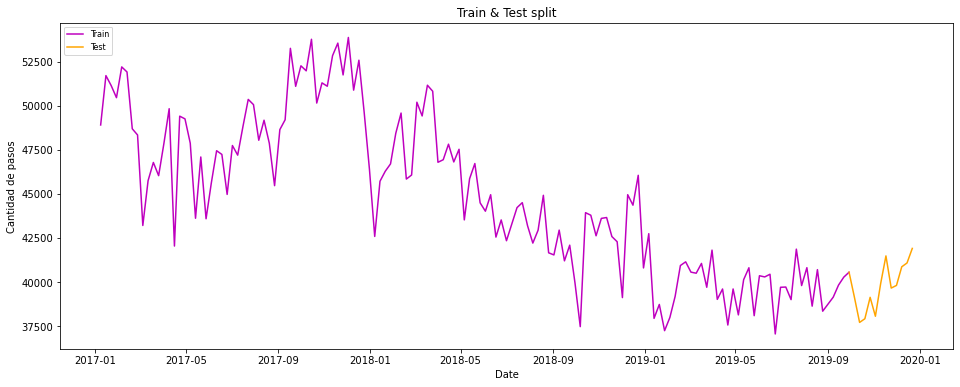

In [236]:
plt.figure (figsize=(16,6))
plt.plot(train, label='Train', color='m')
plt.plot(test, label='Test', color='orange')
plt.title('Train & Test split')
plt.xlabel('Date')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

### ARIMA 

In [237]:
series = train
X = series.values
weeks_in_year = 52
differenced = difference (X, weeks_in_year)

In [238]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(differenced, order=(2,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   91
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -850.716
Date:                Wed, 22 Sep 2021   AIC                           1713.433
Time:                        22:42:48   BIC                           1728.498
Sample:                             0   HQIC                          1719.510
                                 - 91                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4912.0572   1933.969     -2.540      0.011   -8702.566   -1121.548
ar.L1          0.0342      0.260      0.131      0.896      -0.476       0.545
ar.L2          0.7526      0.228      3.305      0.0

- El valor *z* como es  > a 1.96 en todos los casos. (todos son relevantes).
- De la interpretación de los intervalos en valor absoluto, se llega a la conclusión que todos son relevantes.
- Todavía tenemos que comparar modelo con el valor AIC, el menor será el mejor modelo en relación a parámetros pero no necesariamente prediciendo.

In [239]:
start_index = len(differenced)
end_index = start_index +12
forecast = model_fit.predict (start = start_index, end = end_index)

history = [x for x in X]
week =1
for yhat in forecast:
    inverted = inverse_difference (history, yhat, weeks_in_year)
    print ('Week %d: %f' % (week, inverted))
    history.append (inverted)
    week +=1

Week 1: 35933.519348
Week 2: 42588.173283
Week 3: 41538.940790
Week 4: 40484.683528
Week 5: 40794.611983
Week 6: 40905.524988
Week 7: 39318.790446
Week 8: 39053.237953
Week 9: 35504.590790
Week 10: 41349.566712
Week 11: 40468.325407
Week 12: 42160.033288
Week 13: 36690.490401


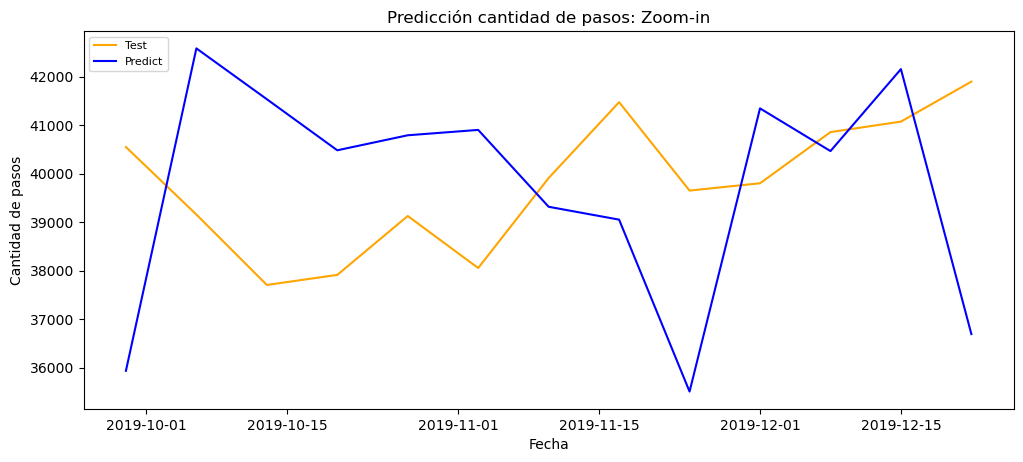

In [240]:
import pandas as pd 

plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test.index, test,label = 'Test', color='orange')
plt.plot(test.index, history[-13:], color = 'blue', label = 'Predict')
plt.title('Predicción cantidad de pasos: Zoom-in')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

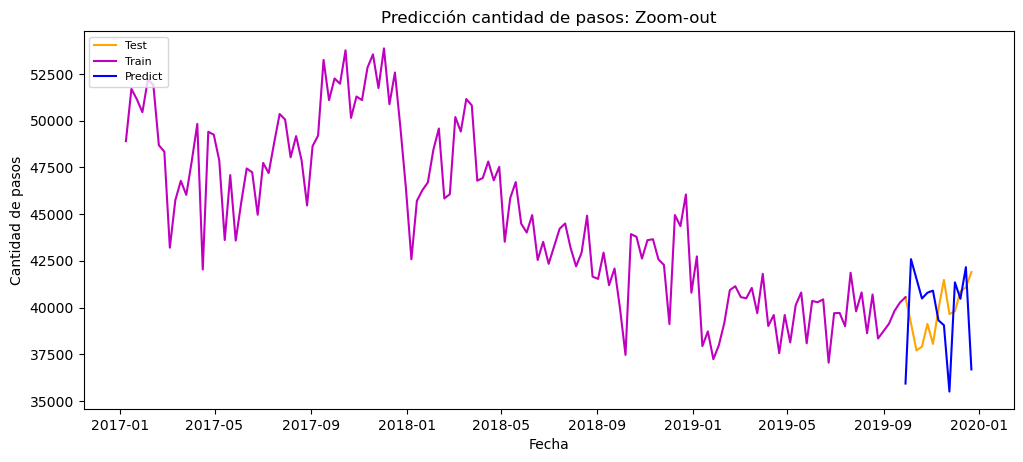

In [241]:
import pandas as pd 

plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test.index, test,label = 'Test', color='orange')
plt.plot(train, label='Train', color='m')
plt.plot(test.index, history[-13:], color = 'blue', label = 'Predict')
plt.title('Predicción cantidad de pasos: Zoom-out')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

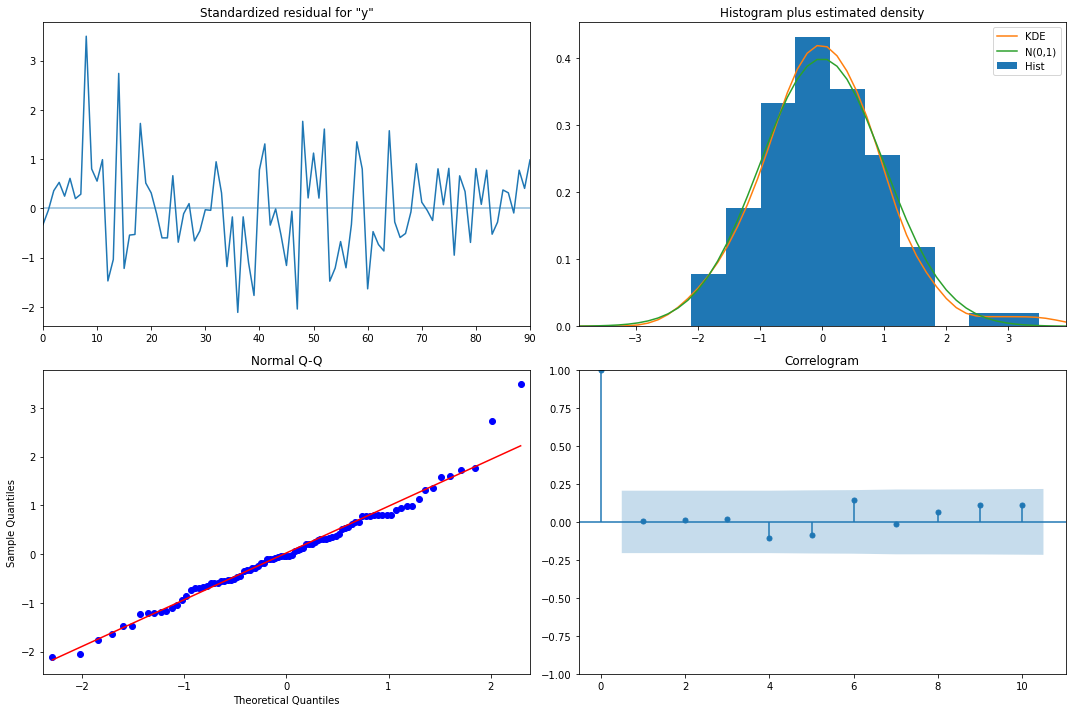

In [91]:
model_fit.plot_diagnostics(figsize=(15,10))
plt.tight_layout()
plt.show()

Del gráfico se puede interpretar que:
- La varianza parecer se constante. 
- La distribución de los errores es similar a la normal.
- Los errores tienden a ajustarse a la línea, aunque hay observaciones que no. 
Esto parecería indicar que en gran medida es ruido blanco.

In [242]:
results_semanal = pd.DataFrame (test, index=test.index)
results_semanal.columns = ['real']
results_semanal['arima_oos_semanal'] = history[-13:]
results_semanal.head(13)

real  arima_oos_semanal
fecha                                      
2019-09-29  40552.285714       35933.519348
2019-10-06  39158.428571       42588.173283
2019-10-13  37705.142857       41538.940790
2019-10-20  37912.857143       40484.683528
2019-10-27  39128.428571       40794.611983
2019-11-03  38054.714286       40905.524988
2019-11-10  39911.857143       39318.790446
2019-11-17  41477.571429       39053.237953
2019-11-24  39653.214286       35504.590790
2019-12-01  39803.571429       41349.566712
2019-12-08  40860.071429       40468.325407
2019-12-15  41077.000000       42160.033288
2019-12-22  41902.571429       36690.490401

In [243]:
rmse_arima_oos_semanal = np.sqrt(mean_squared_error(test, results_semanal.arima_oos_semanal))
print(('RMSE ARIMA out-of-sample semanal:'), rmse_arima_oos_semanal)
mae_arima_oos_semanal =metrics.mean_absolute_error(test, results_semanal.arima_oos_semanal)
print('MAE ARIMA out-of-sample semanal:', mae_arima_oos_semanal)
mape_arima_oos_semanal = np.mean(np.abs(results_semanal.arima_oos_semanal - test)/np.abs(test))
print('MAPE ARIMA out-of-sample semanal:',mape_arima_oos_semanal)

RMSE ARIMA out-of-sample semanal: 3033.5844732111627
MAE ARIMA out-of-sample semanal: 2643.8468308052297
MAPE ARIMA out-of-sample semanal: 0.06658488362173696


In [244]:
from pmdarima.arima import auto_arima
auto_arima_semanal = auto_arima(train, start_p = 0,start_d=0,start_q = 0,
                       max_p = 5,max_d = 3,max_q = 5)

In [245]:
print(auto_arima_semanal.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1301.098
Date:                Wed, 22 Sep 2021   AIC                           2604.197
Time:                        22:43:09   BIC                           2607.153
Sample:                             0   HQIC                          2605.398
                                - 143                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.285e+06   5.14e+05     10.275      0.000    4.28e+06    6.29e+06
Ljung-Box (L1) (Q):                  24.42   Jarque-Bera (JB):                 5.29
Prob(Q):                              0.00   Pr

En base a este resultado se decide hacer la diferencia manual

In [246]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(differenced, order=(0,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   91
Model:                          ARIMA   Log Likelihood                -886.776
Date:                Wed, 22 Sep 2021   AIC                           1777.553
Time:                        22:43:11   BIC                           1782.574
Sample:                             0   HQIC                          1779.579
                                 - 91                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4912.0577    457.535    -10.736      0.000   -5808.810   -4015.305
sigma2      1.763e+07   2.43e+06      7.263      0.000    1.29e+07    2.24e+07
Ljung-Box (L1) (Q):                  43.66   Jarque-

- El valor *z* como es  > a 1.96 en todos los casos. (todos son relevantes).
- De la interpretación de los intervalos en valor absoluto, se llega a la conclusión que todos son relevantes.
- Todavía tenemos que comparar modelo con el valor AIC, el menor será el mejor modelo en relación a parámetros pero no necesariamente prediciendo.

In [247]:
start_index = len(differenced)
end_index = start_index +12
forecast = model_fit.predict (start = start_index, end = end_index)

history = [x for x in X]
week =1
for yhat in forecast:
    inverted = inverse_difference (history, yhat, weeks_in_year)
    print ('Week %d: %f' % (week, inverted))
    history.append (inverted)
    week +=1

Week 1: 32553.275660
Week 2: 39018.037565
Week 3: 38872.942327
Week 4: 37706.656612
Week 5: 38693.228041
Week 6: 38742.942327
Week 7: 37663.370898
Week 8: 37369.085184
Week 9: 34201.156612
Week 10: 40037.513755
Week 11: 39442.513755
Week 12: 41137.513755
Week 13: 35883.513755


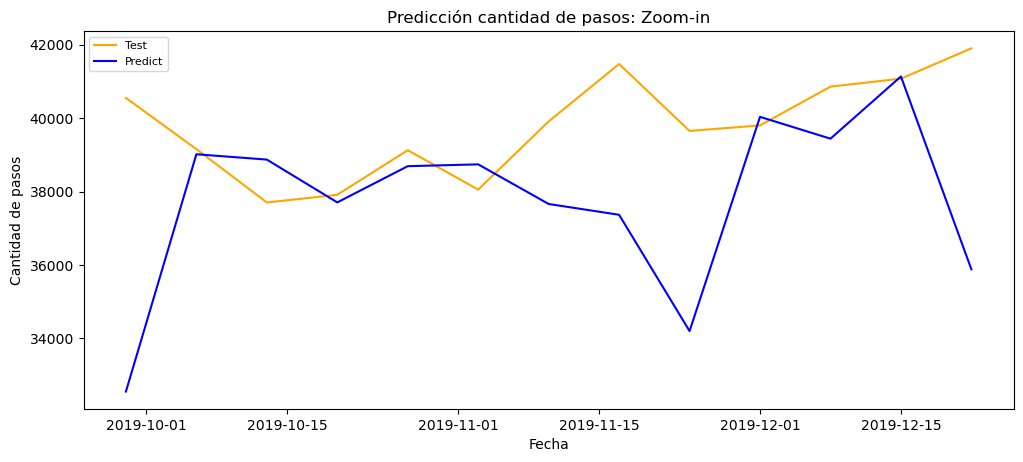

In [248]:
import pandas as pd 

plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test.index, test,label = 'Test', color='orange')
plt.plot(test.index, history[-13:], color = 'blue', label = 'Predict')
plt.title('Predicción cantidad de pasos: Zoom-in')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

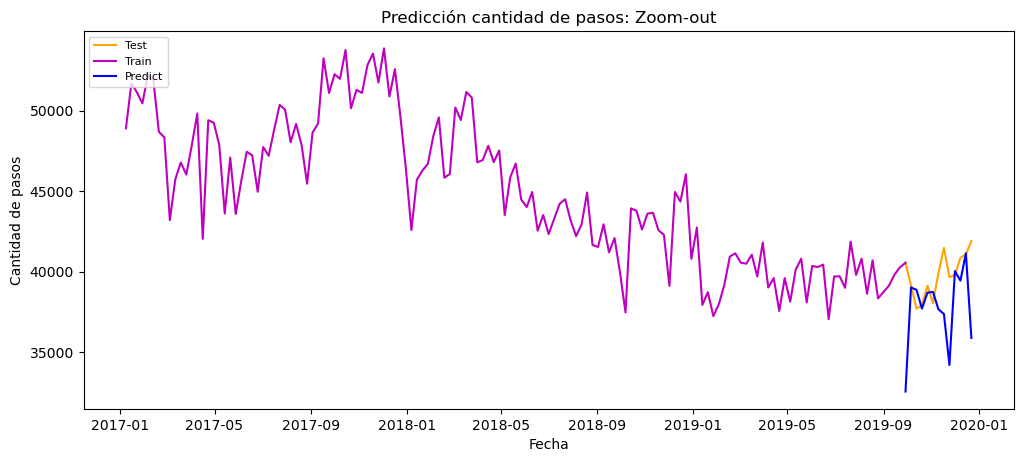

In [249]:
import pandas as pd 

plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test.index, test,label = 'Test', color='orange')
plt.plot(train,label = 'Train', color='m')
plt.plot(test.index, history[-13:], color = 'blue', label = 'Predict')
plt.title('Predicción cantidad de pasos: Zoom-out')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [250]:
results_semanal['auto_arima_oos_semanal'] = history[-13:]
results_semanal.head(13)

real  arima_oos_semanal  auto_arima_oos_semanal
fecha                                                              
2019-09-29  40552.285714       35933.519348            32553.275660
2019-10-06  39158.428571       42588.173283            39018.037565
2019-10-13  37705.142857       41538.940790            38872.942327
2019-10-20  37912.857143       40484.683528            37706.656612
2019-10-27  39128.428571       40794.611983            38693.228041
2019-11-03  38054.714286       40905.524988            38742.942327
2019-11-10  39911.857143       39318.790446            37663.370898
2019-11-17  41477.571429       39053.237953            37369.085184
2019-11-24  39653.214286       35504.590790            34201.156612
2019-12-01  39803.571429       41349.566712            40037.513755
2019-12-08  40860.071429       40468.325407            39442.513755
2019-12-15  41077.000000       42160.033288            41137.513755
2019-12-22  41902.571429       36690.490401            35883.513755

In [251]:
rmse_auto_arima_oos_semanal = np.sqrt(mean_squared_error(test, results_semanal.auto_arima_oos_semanal))
print(('RMSE AUTOARIMA out-of-sample semanal:'), rmse_auto_arima_oos_semanal)
mae_auto_arima_oos_semanal =metrics.mean_absolute_error(test, results_semanal.auto_arima_oos_semanal)
print('MAE AUTOARIMA out-of-sample semanal:', mae_auto_arima_oos_semanal)
mape_auto_arima_oos_semanal = np.mean(np.abs(results_semanal.auto_arima_oos_semanal - test)/np.abs(test))
print('MAPE AUTOARIMA out-of-sample semanal:',mape_auto_arima_oos_semanal)

RMSE AUTOARIMA out-of-sample semanal: 3464.4391435829953
MAE AUTOARIMA out-of-sample semanal: 2321.302401868165
MAPE AUTOARIMA out-of-sample semanal: 0.057309684727527996


### Machine Learning: *Random Forest Regressor*

In [305]:
look_back = 19

In [306]:
semanal_rf = semanal.cantidad_pasos
semanal_rf.head()

fecha
2017-01-08    48904.285714
2017-01-15    51704.571429
2017-01-22    51136.714286
2017-01-29    50452.428571
2017-02-05    52196.428571
Freq: W-SUN, Name: cantidad_pasos, dtype: float64

In [325]:
N = semanal_rf.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(135, 19) (135,)


In [326]:
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = semanal_rf.iloc[i:i+look_back]
    y[i] = semanal_rf.iloc[i+look_back]

In [336]:
N_train = 144 - look_back 
N_test =  10
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(125, 19) (125,)
(10, 19) (10,)


In [337]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp 

rf = RandomForestRegressor()

In [338]:
rs_cv = RandomizedSearchCV(rf, cv=4, n_iter=10, random_state=42 ,
                           param_distributions={'max_features': sp.stats.randint(1,20),
                                                'n_estimators': sp.stats.randint(1,20)})

In [339]:
rs_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12e3f45b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12a627e20>},
                   random_state=42)

In [340]:
print('Los mejores Parametros :'+str(rs_cv.best_params_))
print('El mejor Score: ' +str(rs_cv.best_score_)+'n')

Los mejores Parametros :{'max_features': 7, 'n_estimators': 19}
El mejor Score: -0.7696966751550538n


In [341]:
rf = RandomForestRegressor(n_estimators=19, max_features= 7 ,random_state=42, n_jobs = 4).fit(X_train,y_train)

Un modelo puede ser mejor prediciendo la parte estacional pero no predicción forecasting.

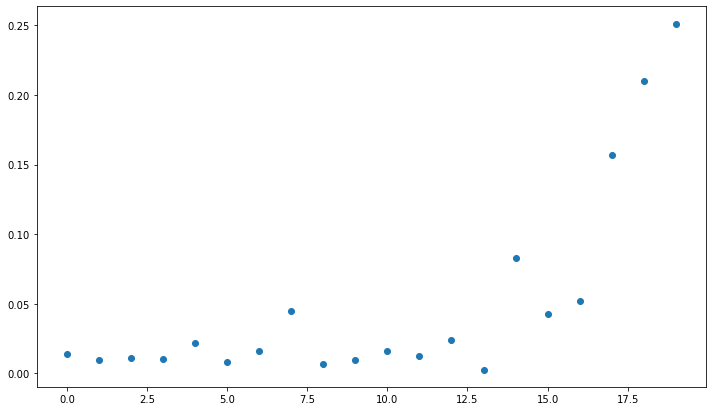

In [301]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)

plt.show()

In [342]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

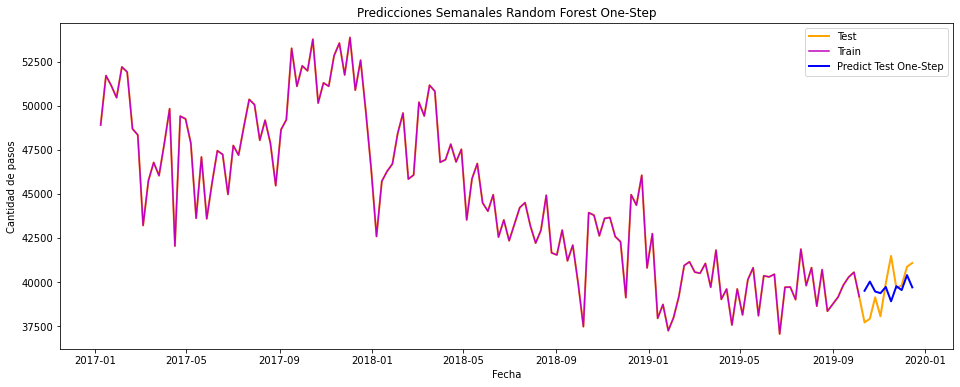

In [343]:
plt.figure(figsize=(16,6))
plt.plot(semanal_rf.index[:length_total], semanal_rf[:length_total],lw = 2, label = 'Test', color='orange')
plt.plot(semanal_rf.index[:N_train + look_back], semanal_rf[:N_train + look_back], label = 'Train', color='m')
plt.plot(semanal_rf.index[N_train+look_back: length_total], y_test_pred, lw = 2, label = 'Predict Test One-Step', color='b')
plt.legend()
plt.title('Predicciones Semanales Random Forest One-Step')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()

In [344]:
rmse_rf_os_semanal = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(('RMSE Random forest semanal One Step:'), rmse_rf_os_semanal)
mae_rf_os_semanal =metrics.mean_absolute_error(y_test, y_test_pred)
print('MAE Random forest semanal One Step:', mae_rf_os_semanal)
mape_rf_os_semanal = np.mean(np.abs(y_test_pred - y_test)/np.abs(y_test))
print('MAPE Random forest semanal One Step:',mape_rf_os_semanal)

RMSE Random forest semanal One Step: 1356.043801067072
MAE Random forest semanal One Step: 1054.352882205513
MAPE Random forest semanal One Step: 0.026769589838359347


#### Multi-Step Prediction

In [345]:
y_ms_test_pred = []
x = X_test[0,:] 
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

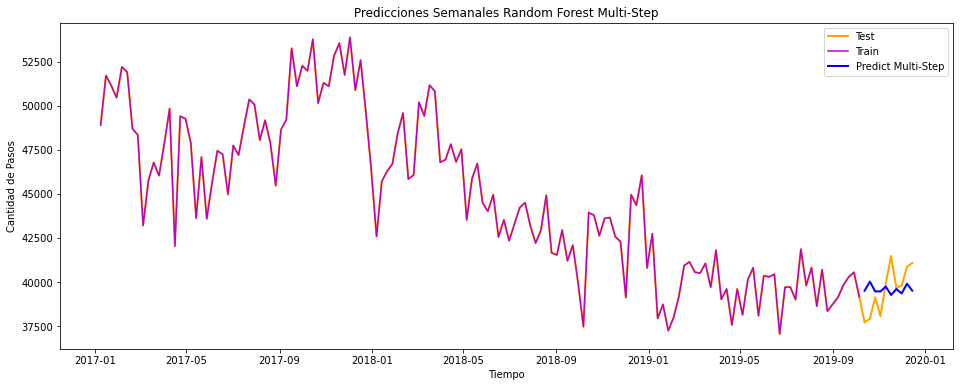

In [346]:
plt.figure(figsize=(16,6))
plt.plot(semanal_rf.index[:length_total], semanal_rf[:length_total],lw = 2, label = 'Test', color='orange')
plt.plot(semanal_rf.index[:N_train + look_back], semanal_rf[:N_train + look_back], label = 'Train', color='m')
plt.plot(semanal_rf.index[N_train+look_back: length_total], y_ms_test_pred, lw = 2, label = 'Predict Multi-Step', color='b')
plt.legend()
plt.xlabel('Tiempo')
plt.title('Predicciones Semanales Random Forest Multi-Step')
plt.ylabel('Cantidad de Pasos')
plt.show()

In [347]:
rmse_rf_ms_semanal = np.sqrt(mean_squared_error(y_test, y_ms_test_pred))
print(('RMSE Random forest semanal Multi Step:'), rmse_rf_ms_semanal)
mae_rf_ms_semanal =metrics.mean_absolute_error(y_test, y_ms_test_pred)
print('MAE Random forest semanal Multi Step:', mae_rf_ms_semanal)
mape_rf_ms_semanal = np.mean(np.abs(y_ms_test_pred - y_test)/np.abs(y_test))
print('MAPE Random forest semanal Multi Step:',mape_rf_ms_semanal)

RMSE Random forest semanal Multi Step: 1353.2838391463185
MAE Random forest semanal Multi Step: 1108.3686716791956
MAPE Random forest semanal Multi Step: 0.02802708796325331


### Comparación de Resultados

#### Diario

In [348]:
print(('RMSE ARIMA out-of-sample diario:'), rmse_arima_oos)
print(('RMSE Random forest diario One Step:'), rmse_rf_os)
print(('RMSE Random forest diario Multi Step:'), rmse_rf_ms)

RMSE ARIMA out-of-sample diario: 5921.060794559261
RMSE Random forest diario One Step: 3167.334355160505
RMSE Random forest diario Multi Step: 3341.4019919492584


In [349]:
print('MAE ARIMA out-of-sample diario:', mae_arima_oos)
print('MAE Random forest diario One Step:', mae_rf_os)
print('MAE Random forest diario Multi Step:', mae_rf_ms)

MAE ARIMA out-of-sample diario: 4561.138207731392
MAE Random forest diario One Step: 2526.5274904214557
MAE Random forest diario Multi Step: 2650.9224457215832


In [350]:
print('MAPE ARIMA out-of-sample diario:',mape_arima_oos)
print('MAPE Random forest diario One Step:',mape_rf_os)
print('MAPE Random forest diario Multi Step:',mape_rf_ms)

MAPE ARIMA out-of-sample diario: 0.1154437674139565
MAPE Random forest diario One Step: 0.06595776325966617
MAPE Random forest diario Multi Step: 0.0881920306269069


#### Semanal

In [351]:
print(('RMSE ARIMA out-of-sample semanal:'), rmse_arima_oos_semanal)
print(('RMSE Random forest semanal One Step:'), rmse_rf_os_semanal)
print(('RMSE Random forest semanal Multi Step:'), rmse_rf_ms_semanal)
print(('RMSE AUTOARIMA out-of-sample semanal:'), rmse_auto_arima_oos_semanal)

RMSE ARIMA out-of-sample semanal: 3033.5844732111627
RMSE Random forest semanal One Step: 1356.043801067072
RMSE Random forest semanal Multi Step: 1353.2838391463185
RMSE AUTOARIMA out-of-sample semanal: 3464.4391435829953


In [352]:
print('MAE ARIMA out-of-sample semanal:', mae_arima_oos_semanal)
print('MAE Random forest semanal One Step:', mae_rf_os_semanal)
print('MAE Random forest semanal Multi Step:', mae_rf_ms_semanal)
print('MAE AUTOARIMA out-of-sample semanal:', mae_auto_arima_oos_semanal)

MAE ARIMA out-of-sample semanal: 2643.8468308052297
MAE Random forest semanal One Step: 1054.352882205513
MAE Random forest semanal Multi Step: 1108.3686716791956
MAE AUTOARIMA out-of-sample semanal: 2321.302401868165


In [353]:
print('MAPE ARIMA out-of-sample semanal:',mape_arima_oos_semanal)
print('MAPE Random forest semanal One Step:',mape_rf_os_semanal)
print('MAPE Random forest semanal Multi Step:',mape_rf_ms_semanal)
print('MAPE AUTOARIMA out-of-sample semanal:',mape_auto_arima_oos_semanal)

MAPE ARIMA out-of-sample semanal: 0.06658488362173696
MAPE Random forest semanal One Step: 0.026769589838359347
MAPE Random forest semanal Multi Step: 0.02802708796325331
MAPE AUTOARIMA out-of-sample semanal: 0.057309684727527996


## Implementación Adicional

*1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?*

Implementaría otros modelos para diferentes sentidos ya que tienen tendencias muy diferentes. Esto lo haré en el Proyecto IV. 
 
En el caso de forma de pago, en este análisis que incluye solamente efectivo vemos que la tendencia es negativa. Al analizar las diferentes formas de pago podremos ver si se ha migrado a telepase por ejemplo. 

### Nuevo modelo

In [540]:
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')

In [541]:
data_2020.head()

periodo                fecha    mes        dia  dia_fecha  hora_inicio  \
0   2020.0  2020-01-01 00:00:00  enero  Miércoles        1.0          0.0   
1   2020.0  2020-01-01 00:00:00  enero  Miércoles        1.0          0.0   
2   2020.0  2020-01-01 00:00:00  enero  Miércoles        1.0          0.0   
3   2020.0  2020-01-01 00:00:00  enero  Miércoles        1.0          0.0   
4   2020.0  2020-01-01 00:00:00  enero  Miércoles        1.0          0.0   

   hora_fin estacion tipo_vehiculo forma_pago  \
0       1.0  ALBERDI          Auto   Efectivo   
1       1.0  ALBERDI          Auto   Efectivo   
2       1.0  ALBERDI          Auto  Rec.Deuda   
3       1.0  ALBERDI          Auto  Rec.Deuda   
4       1.0  ALBERDI          Auto  Rec.Deuda   

                        observacion    sentido  cantidad_pasos  
0                          Efectivo     Centro            24.0  
1                          Efectivo  Provincia            80.0  
2                Paso en Infracción  Provincia             1.0  
3  Paso en infracción con Multa LPR     Centro             1.0  
4  Paso en infracción con Multa LPR  Provincia             1.0

In [542]:
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask]

In [543]:
data_2020.drop(columns =['hora_inicio', 'periodo','estacion', 'forma_pago', 'observacion', 'mes', 'dia_fecha'], inplace=True)
data_2020.head()

fecha        dia  hora_fin tipo_vehiculo    sentido  \
52   2020-01-01 00:00:00  Miércoles       1.0          Auto     Centro   
53   2020-01-01 00:00:00  Miércoles       1.0          Auto  Provincia   
134  2020-01-01 00:00:00  Miércoles       2.0          Auto     Centro   
135  2020-01-01 00:00:00  Miércoles       2.0          Auto  Provincia   
202  2020-01-01 00:00:00  Miércoles       3.0          Auto     Centro   

     cantidad_pasos  
52            326.0  
53            319.0  
134           199.0  
135           180.0  
202           114.0

In [544]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

data_2020.head()

dia tipo_vehiculo    sentido  cantidad_pasos              fecha2
52   Miércoles          Auto     Centro           326.0 2020-01-01 01:00:00
53   Miércoles          Auto  Provincia           319.0 2020-01-01 01:00:00
134  Miércoles          Auto     Centro           199.0 2020-01-01 02:00:00
135  Miércoles          Auto  Provincia           180.0 2020-01-01 02:00:00
202  Miércoles          Auto     Centro           114.0 2020-01-01 03:00:00

In [545]:
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 
data_2020.head()

dia tipo_vehiculo    sentido  cantidad_pasos               fecha
52   Miércoles          Auto     Centro           326.0 2020-01-01 01:00:00
53   Miércoles          Auto  Provincia           319.0 2020-01-01 01:00:00
134  Miércoles          Auto     Centro           199.0 2020-01-01 02:00:00
135  Miércoles          Auto  Provincia           180.0 2020-01-01 02:00:00
202  Miércoles          Auto     Centro           114.0 2020-01-01 03:00:00

In [546]:
data_2020.sort_values('fecha', inplace = True)
data_2020.reset_index(drop=True, inplace = True)
data_2020

dia   tipo_vehiculo    sentido  cantidad_pasos  \
0      Miércoles            Moto     Centro             7.0   
1      Miércoles            Auto  Provincia           423.0   
2      Miércoles            Auto     Centro           467.0   
3      Miércoles            Moto  Provincia             6.0   
4      Miércoles  Pesados 2 Ejes     Centro             1.0   
...          ...             ...        ...             ...   
52369     Jueves            Auto  Provincia           222.0   
52370     Jueves            Auto  Provincia           106.0   
52371     Jueves            Moto     Centro             5.0   
52372     Jueves            Moto  Provincia             1.0   
52373     Jueves            Auto     Centro           103.0   

                    fecha  
0     2020-01-01 00:00:00  
1     2020-01-01 00:00:00  
2     2020-01-01 00:00:00  
3     2020-01-01 00:00:00  
4     2020-01-01 00:00:00  
...                   ...  
52369 2020-12-31 20:00:00  
52370 2020-12-31 21:00:00  
52371 2020-12-31 21:00:00  
52372 2020-12-31 21:00:00  
52373 2020-12-31 21:00:00  

[52374 rows x 5 columns]

In [547]:
diario= data_2020.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(366, 1)


cantidad_pasos
fecha                     
2020-01-01         21395.0
2020-01-02         33722.0
2020-01-03         37067.0
2020-01-04         30627.0
2020-01-05         27812.0

In [548]:
semanal_2020 = diario.resample("W", closed='left').mean()
semanal_2020

cantidad_pasos
fecha                     
2020-01-05    30702.750000
2020-01-12    34515.428571
2020-01-19    35354.142857
2020-01-26    34251.285714
2020-02-02    36254.142857
2020-02-09    35151.142857
2020-02-16    37401.428571
2020-02-23    37003.857143
2020-03-01    33896.428571
2020-03-08    36288.714286
2020-03-15    33171.285714
2020-03-22    18035.000000
2020-03-29        0.000000
2020-04-05        0.000000
2020-04-12        0.000000
2020-04-19        0.000000
2020-04-26        0.000000
2020-05-03        0.000000
2020-05-10        0.000000
2020-05-17        0.142857
2020-05-24     6793.714286
2020-05-31     7868.857143
2020-06-07     9991.142857
2020-06-14    10926.142857
2020-06-21    10188.000000
2020-06-28    11566.285714
2020-07-05    10681.142857
2020-07-12     8647.571429
2020-07-19    11066.285714
2020-07-26    12051.142857
2020-08-02    13181.285714
2020-08-09    13375.000000
2020-08-16    13346.285714
2020-08-23    11652.285714
2020-08-30    11836.857143
2020-09-06    11024.857143
2020-09-13    11140.857143
2020-09-20     9974.714286
2020-09-27     9025.571429
2020-10-04     5114.714286
2020-10-11     4932.142857
2020-10-18     5247.285714
2020-10-25     5504.857143
2020-11-01     5899.000000
2020-11-08     6886.285714
2020-11-15     7392.714286
2020-11-22     8639.000000
2020-11-29     8455.428571
2020-12-06     9502.000000
2020-12-13     9580.857143
2020-12-20    10332.571429
2020-12-27     9668.571429
2021-01-03     9972.200000

In [549]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')

In [550]:
dataset = pd.concat([data_2019, data_2018, data_2017, data_2016])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [551]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [552]:
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [553]:
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Viernes     Centro       Liviano              14 2016-01-01 00:00:00
1       Viernes     Centro        Pesado               3 2016-01-01 00:00:00
2       Viernes  Provincia       Liviano              66 2016-01-01 00:00:00
3       Viernes  Provincia        Pesado               1 2016-01-01 00:00:00
4       Viernes  Provincia        Pesado               4 2016-01-01 00:00:00
...         ...        ...           ...             ...                 ...
346561   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
346562   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
346563   Martes     Centro       Liviano             580 2019-12-31 22:00:00
346564   Martes     Centro       Liviano             214 2019-12-31 23:00:00
346565   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[346566 rows x 5 columns]

In [554]:
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1461, 1)


cantidad_pasos
fecha                     
2016-01-01           25602
2016-01-02           36136
2016-01-03           37225
2016-01-04           50312
2016-01-05           49907

In [555]:
diario.cantidad_pasos[diario.cantidad_pasos < 30000] = np.nan

In [556]:
print(diario.isna().sum())
diario = diario.interpolate()
print(diario.isna().sum())

cantidad_pasos    44
dtype: int64
cantidad_pasos    1
dtype: int64


In [557]:
semanal = diario.resample("W", closed='left').mean()

In [558]:
dataset = pd.concat([semanal, semanal_2020])

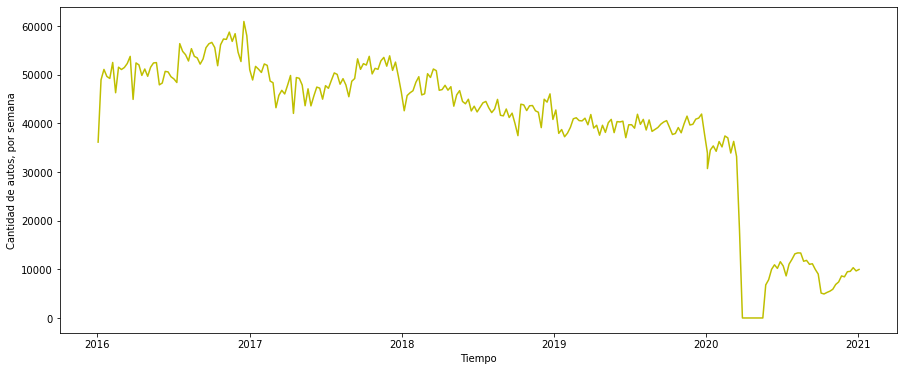

In [559]:
plt.figure(figsize = (15,6))
plt.plot(dataset.index, dataset.cantidad_pasos, color='y')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

/opt/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


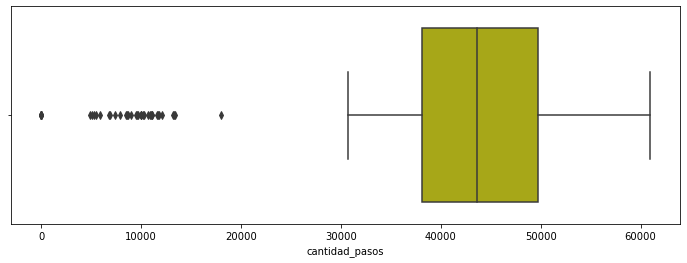

In [560]:
plt.figure(figsize = (12,4))
sns.boxplot(dataset.cantidad_pasos, color='y')
plt.show()

In [561]:
train = dataset.cantidad_pasos[:212]
test = dataset.cantidad_pasos[-52:]

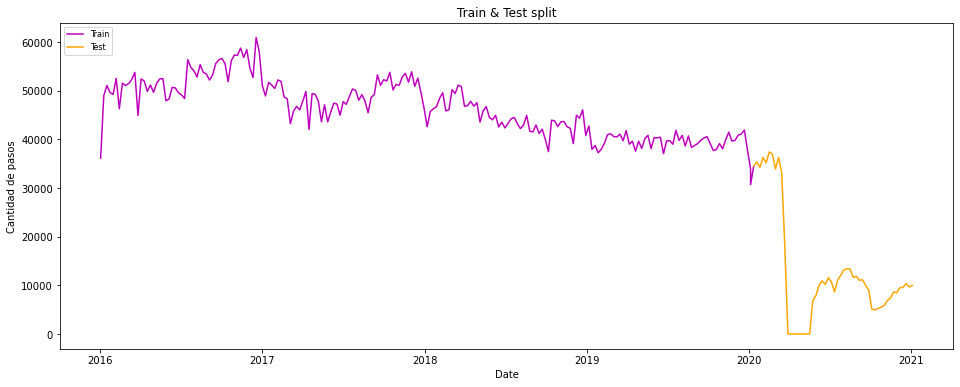

In [562]:
plt.figure (figsize=(16,6))
plt.plot(train, label='Train', color='m')
plt.plot(test, label='Test', color='orange')
plt.title('Train & Test split')
plt.xlabel('Date')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

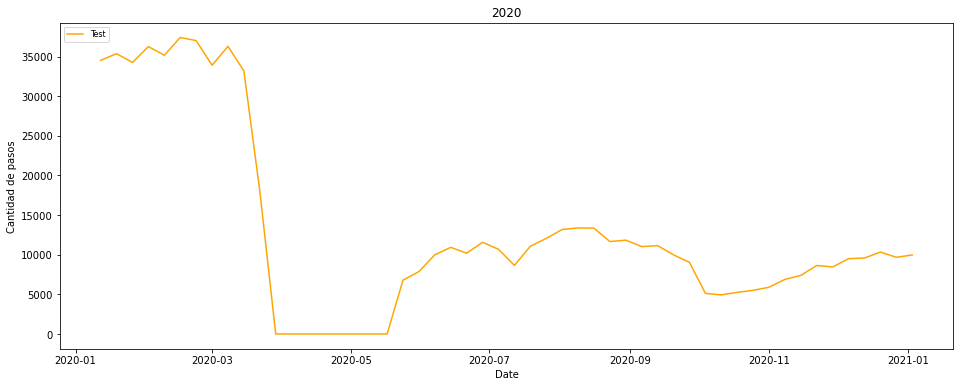

In [563]:
plt.figure (figsize=(16,6))
plt.plot(test, label='Test', color='orange')
plt.title('2020')
plt.xlabel('Date')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

Del gráfico se puede concluir que hubo una baja notable en la cantidad de pasos en marzo 2020 debido a las medidas restrictivas de la cuarentena. En mayo del 2020 empezó a subir la cantidad de paso pero no se alcanzó los niveles anteriores. Dado que el 2020 es un año "outlier" ya que es muy diferente, el modelo no podrá predecir bien. 

### Modelo elegido: *Random Forest One Step*

In [570]:
semanal = dataset

In [571]:
look_back = 30

In [572]:
semanal_rf = semanal.cantidad_pasos
semanal_rf.head()

fecha
2016-01-03    36136.000000
2016-01-10    48934.857143
2016-01-17    51076.000000
2016-01-24    49629.714286
2016-01-31    49221.714286
Name: cantidad_pasos, dtype: float64

In [573]:
N = semanal_rf.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(232, 30) (232,)


In [574]:
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = semanal_rf.iloc[i:i+look_back]
    y[i] = semanal_rf.iloc[i+look_back]

In [575]:
N_train = 212 - look_back 
N_test =  50
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(182, 30) (182,)
(50, 30) (50,)


In [576]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp 

In [577]:
rf = RandomForestRegressor(n_estimators=19, max_features= 7 ,random_state=42, n_jobs = 4).fit(X_train,y_train)

Un modelo puede ser mejor prediciendo la parte estacional pero no predicción forecasting.

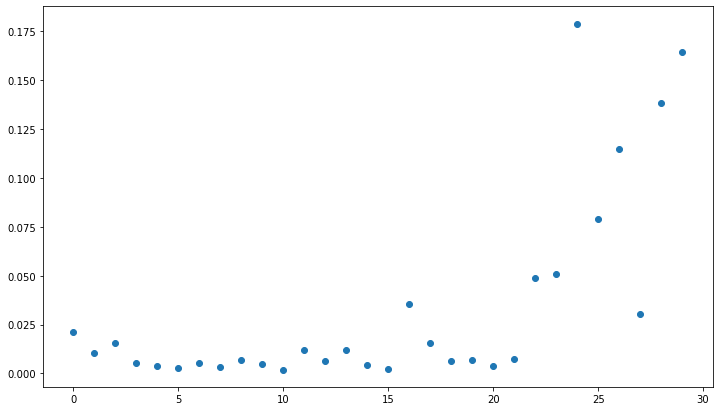

In [578]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)

plt.show()

In [579]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

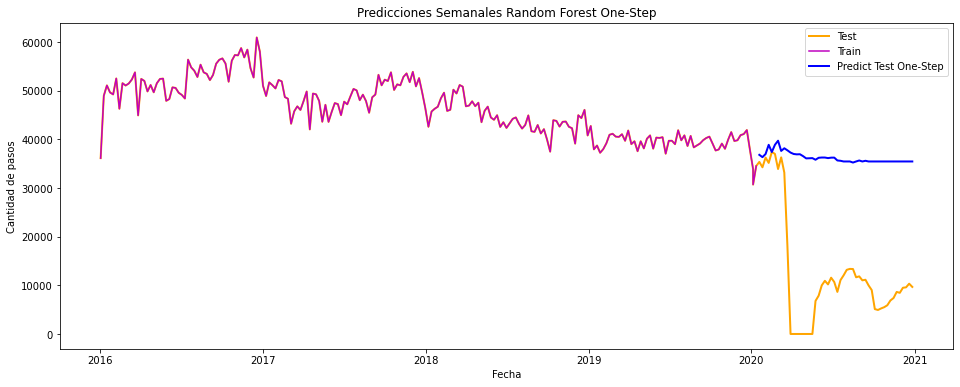

In [580]:
plt.figure(figsize=(16,6))
plt.plot(semanal_rf.index[:length_total], semanal_rf[:length_total],lw = 2, label = 'Test', color='orange')
plt.plot(semanal_rf.index[:N_train + look_back], semanal_rf[:N_train + look_back], label = 'Train', color='y')
plt.plot(semanal_rf.index[N_train+look_back: length_total], y_test_pred, lw = 2, label = 'Predict Test One-Step', color='b')
plt.legend()
plt.title('Predicciones Semanales Random Forest One-Step')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()

In [582]:
rmse_rf_os_semanal = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(('RMSE Random forest semanal One Step:'), rmse_rf_os_semanal)
mae_rf_os_semanal =metrics.mean_absolute_error(y_test, y_test_pred)
print('MAE Random forest semanal One Step:', mae_rf_os_semanal)

RMSE Random forest semanal One Step: 25826.578552625622
MAE Random forest semanal One Step: 23459.958320801994


Del gráfico ya podemos ver que la predicción no es buena como fue anticipado ya que el 2020 es un año atípico.

# Conclusiones
-------------

Para el último trimestre de 2019 los resultados obtenidos con Random forest One Step son buenos, sin embargo para el 2020 no, ya que es un año atípico.

#### Pensando en el Proyecto IV... 

- El comportamiento del tránsito pesado y del tránsito liviano es muy diferente. El tránsito pesado puede estar haciendo ruido por eso sería interesante hacer un modelo especial para el tránsito pesado. Puede verse como diferentes problemas que necesitan diferentes modelos.
- Es necesario considerar otras formas de pago no solamente pago en efectivo ya que se ve una migración hacia el telepase. La tendencia del pago en efectivo es a la baja.

El modelo para el último trimestre de 2019 se podría mejorar con redes neuronales o prophet. También sería interesante incluir información de feriados y variables exógenas.

Sin embargo para predecir 2020 considero que es muy difícil tener un buen modelo ya que es un año "outlier". 